# S&P500 Example: Hedging of an Asian Put Option

First import the necessary packages

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines
from matplotlib import rc
from matplotlib import style
style.use('ggplot')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.optimize import minimize
from matplotlib import rcParams
from Functions import*

Only execute next box if program should run on a GPU

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Load the Data of 20 of the largest constituents

In [3]:
stocks =[]
stocks += [pd.read_csv("time_series/AAPL.OQ.csv")] #Apple Inc.
stocks += [pd.read_csv("time_series/MSFT.OQ.csv")] # Microsoft Corporation 
stocks += [pd.read_csv("time_series/AMZN.OQ.csv")] # Amazon.com Inc.
stocks += [pd.read_csv("time_series/GOOGL.OQ.csv")] #Alphabet Inc. Class C
stocks += [pd.read_csv("time_series/BRKb.N.csv")] # Berkshire Hathaway Inc. Class B
stocks += [pd.read_csv("time_series/JPM.N.csv")] #JPMorgan Chase & Co.
stocks += [pd.read_csv("time_series/JNJ.N.csv")] #Johnson & Johnson
stocks += [pd.read_csv("time_series/V.N.csv")] # Visa Inc. Class A
stocks += [pd.read_csv("time_series/UNH.N.csv")] #UnitedHealth Group Incorporated
stocks += [pd.read_csv("time_series/NVDA.OQ.csv")] #NVIDIA Corporation
stocks += [pd.read_csv("time_series/PG.N.csv")] #Procter & Gamble Company
stocks += [pd.read_csv("time_series/HD.N.csv")] #Home Depot Inc.
stocks += [pd.read_csv("time_series/MA.N.csv")] # Mastercard Incorporated Class A
stocks += [pd.read_csv("time_series/BAC.N.csv")] # Bank of America Corp
stocks += [pd.read_csv("time_series/DIS.N.csv")] # Walt Disney Company
stocks += [pd.read_csv("time_series/CMCSA.OQ.csv")] #Comcast Corporation Class A
stocks += [pd.read_csv("time_series/XOM.N.csv")] #Exxon Mobil Corporation
stocks += [pd.read_csv("time_series/ADBE.OQ.csv")] # Adobe Inc.
stocks += [pd.read_csv("time_series/VZ.N.csv")] #Verizon Communications Inc.
stocks += [pd.read_csv("time_series/INTC.OQ.csv")] # Intel Corporation


for i in range(len(stocks)):
    # Clean the NaNs
    stocks[i] = stocks[i].dropna()
    # Reset Indices
    stocks[i] = stocks[i].reset_index()
    # Only Dates and Close Values
    stocks[i]  = stocks[i] [["Date","CLOSE"]]

We plot the normalized evolution of the 20 considered stocks

In [34]:
# Increase the size of xticks and yticks
labelsize = 18
rcParams['xtick.labelsize'] = labelsize
rcParams['ytick.labelsize'] = labelsize 

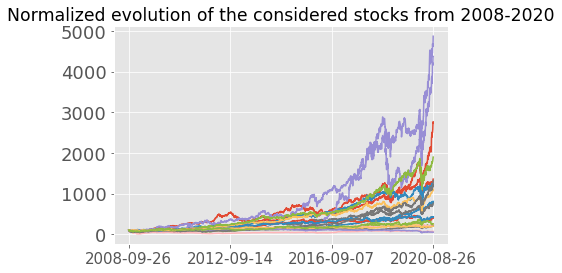

In [47]:
normalized_stocks = []
for i in range(len(stocks)):
    normalized_stocks+=[(100*stocks[i]["CLOSE"]/stocks[i]["CLOSE"][0]).tolist()]
for i in range(len(normalized_stocks)):
    plt.plot(range(len(normalized_stocks[i])),normalized_stocks[i])
plt.title("Normalized evolution of the considered stocks from 2008-2020",fontsize='xx-large')
xtick_numbers = [0,1000,2000,2999]
plt.xticks(xtick_numbers, stocks[0]["Date"].iloc[xtick_numbers], fontsize=15) # Scale here down
plt.show()

We focus on the test period (Feb 2020 - Mar 2020)
and plot the normalized evolution in this period.

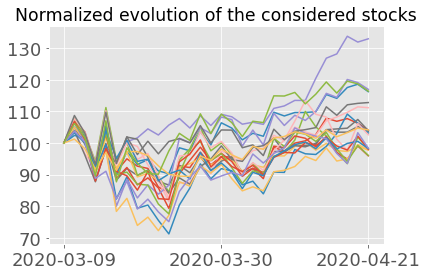

In [45]:
start_index = 2880
end_index = 2910
period = np.arange(start_index,end_index) # Feb to March 2020
normalized_stocks_period_2 = []
for i in range(len(stocks)):
    normalized_stocks_period_2+=[(100*stocks[i]["CLOSE"][start_index:end_index]/stocks[i]["CLOSE"][start_index]).tolist()]
for i in range(len(normalized_stocks_period_2)):
    plt.plot(range(len(normalized_stocks_period_2[i])),normalized_stocks_period_2[i])
plt.figsize=(3, 2)
plt.title("Normalized evolution of the considered stocks",fontsize = 'xx-large')
xtick_numbers = [start_index,start_index+15,end_index]
plt.xticks([0,15,29], stocks[0]["Date"].iloc[xtick_numbers])
plt.yticks(np.arange(70,140,10), np.arange(70,140,10))
plt.savefig('eps/fig_evolution_normalized.eps', format='eps')
plt.show()

# Maxmimum Likelihood Estimation for all constituents

Define the function for the estimation (Can choose between stochastic gradient descent, gradient descent, and ADAM Optimizer)

In [19]:
def compute_max_parameters(x, 
                           iterations = 10000,
                           learning_rate= 0.001,
                           initial_guess= [0.25,0.25,0.05,0,0.75],
                           tolerance = 10e-8,
                           method = 'Adam'):
    x_0 = np.array(initial_guess) #Initial guess
    eps = tolerance # Tolerance to avoid that fractions and log-expressions become inf or -inf
    
    #Definte the Log-Likelihood Function
    def log_likelihood(param):
        a_0 = param[0]
        a_1 = param[1]
        b_0 = param[2]
        b_1 = param[3]
        gamma = param[4]
        constant = np.sqrt(2*np.pi)
        l= [np.log(1/((a_0+a_1*np.maximum(x[i],0))**gamma*constant+eps)+eps)-0.5*((x[i+1]-b_0-(1+b_1)*x[i])/(a_0+a_1*np.maximum(x[i],0)+eps)**gamma)**2 for i in range(len(x)-1)]
        return -np.mean(l) # Mean instead of sum to have smaller values
    
    #Provide the gradients of the log-likelihood
    def derivative(param):
        a_0 = param[0]
        a_1 = param[1]
        b_0 = param[2]
        b_1 = param[3]
        gamma = param[4]
        d1 = [gamma*(a_0+a_1*np.maximum(x[i],0))**(-2*gamma-1)*((x[i+1]-b_0-(1+b_1)*x[i]))**2-(gamma)/(a_0+a_1*np.maximum(x[i],0)+eps) for i in range(len(x)-1)]
        d1 = -np.mean(d1)
        d2 = [gamma*np.maximum(x[i],0)*(a_0+a_1*np.maximum(x[i],0))**(-2*gamma-1)*((x[i+1]-b_0-(1+b_1)*x[i]))**2-(gamma*np.maximum(x[i],0))/(a_0+a_1*np.maximum(x[i],0)+eps) for i in range(len(x)-1)]
        d2 = -np.mean(d2)
        d3 = [(x[i+1]-b_0-(1+b_1)*x[i])/((a_0+a_1*np.maximum(x[i],0)+eps)**(2*gamma)) for i in range(len(x)-1)]
        d3 = -np.mean(d3)
        d4 = [x[i]*(x[i+1]-b_0-(1+b_1)*x[i])/((a_0+a_1*np.maximum(x[i],0)+eps)**(2*gamma)) for i in range(len(x)-1)]
        d4 = -np.mean(d4)
        d5 = [np.log(a_0+a_1*np.maximum(x[i],0)+eps)*((-x[i+1]+b_0+(1+b_1)*x[i])**2/((a_0+a_1*np.maximum(x[i],0)+eps)**(2*gamma))-1)for i in range(len(x)-1)]
        d5 = -np.mean(d5)        
        return np.array([d1,d2,d3,d4,d5])


        return(param)
    
    def derivative_sgd(param,index):
        a_0 = param[0]
        a_1 = param[1]
        b_0 = param[2]
        b_1 = param[3]
        gamma = param[4]
        d1 = [gamma*(a_0+a_1*np.maximum(x[i],0))**(-2*gamma-1)*((x[i+1]-b_0-(1+b_1)*x[i]))**2-(gamma)/(a_0+a_1*np.maximum(x[i],0)+eps) for i in range(len(x)-1)]
        d2 = [gamma*np.maximum(x[i],0)*(a_0+a_1*np.maximum(x[i],0))**(-2*gamma-1)*((x[i+1]-b_0-(1+b_1)*x[i]))**2-(gamma*np.maximum(x[i],0))/(a_0+a_1*np.maximum(x[i],0)+eps) for i in range(len(x)-1)]
        d3 = [(x[i+1]-b_0-(1+b_1)*x[i])/((a_0+a_1*np.maximum(x[i],0)+eps)**(2*gamma)) for i in range(len(x)-1)]
        d4 = [x[i]*(x[i+1]-b_0-(1+b_1)*x[i])/((a_0+a_1*np.maximum(x[i],0)+eps)**(2*gamma)) for i in range(len(x)-1)]
        d5 = [np.log(a_0+a_1*np.maximum(x[i],0)+eps)*((-x[i+1]+b_0+(1+b_1)*x[i])**2/((a_0+a_1*np.maximum(x[i],0)+eps)**(2*gamma))-1)for i in range(len(x)-1)]    
        return np.array([-d1[index],-d2[index],-d3[index],-d4[index],-d5[index]])
    
    def gradient_descent(x_0,alpha=0.001,max_iter=1000):
        # Decay of the learning rate
        def l_r(iteration):
            return alpha*(10./(iteration+10))
        history=[]
        # Initial value for the parameters
        param=x_0
        for i in range(max_iter):
            param = np.maximum(param - l_r(i)*derivative(param),[0,0,-np.inf,-np.inf,0.1])
            history+=[log_likelihood(param)]
        plt.plot(range(iterations),history)
        return(param)
        
    def Adam(x_0,alpha=0.001,p1 = 0.9,p2=0.999,max_iter=1000):
        s = 0
        r = 0
        history=[]
        # Initial value for the parameters
        param=x_0
        for i in range(max_iter):
            index = np.random.randint(0,len(x)-1) # Choose Random Index
            gradient = derivative_sgd(param,index)
            s = p1*s+(1-p1)*gradient
            r = p2*r+(1-p2)*gradient**2
            s_hat = s/(1-p1**(i+1))
            r_hat = r/(1-p2**(i+1))
            update = -alpha*(s_hat/(np.sqrt(r_hat)+eps))
            param = np.maximum(param +update,[0,0,-np.inf,-np.inf,0.1])
            history+=[log_likelihood(param)]
        plt.plot(range(iterations),history)
        return(param)
    
    def stochastic_gradient_descent(x_0,alpha=0.001,p1 = 0.9,p2=0.999,max_iter=1000):
        history=[]
        # Initial value for the parameters
        param=x_0
        def l_r(iteration):
            return alpha*(10./(iteration+10))
        history=[]
        # Initial value for the parameters
        param=x_0
        for i in range(max_iter):
            index = np.random.randint(0,len(x)-1) # Choose Random Index
            param = np.maximum(param - l_r(i)*derivative_sgd(param,index),[0,0,-np.inf,-np.inf,0.1])
            history+=[log_likelihood(param)]
        plt.plot(range(iterations),history)
        return(param)
    
    if method == 'sgd':
        return stochastic_gradient_descent(x_0,alpha=learning_rate,max_iter=iterations)
    if method == 'Adam':
        return Adam(x_0,alpha=learning_rate,max_iter=iterations)
    if method == 'gradient_descent':
        return gradient_descent(x_0,alpha=learning_rate,max_iter=iterations)

Determination of MLE-Parameters (Takes very long)

In [7]:
start_index = 2880
end_index = 2910
list_parameters=[]

for j in range(len(stocks)):
    print("MLE for stock {}".format((str(j))))
    #Create lists for the parameters
    list_a0 = []
    list_a1 = []
    list_b0 = []
    list_b1 = []
    list_gamma = []
    list_a0_rescaled = []
    list_a1_rescaled = []
    list_b0_rescaled = []
    list_b1_rescaled = []
    
    #Compute optimal parameters
    for i in np.arange(279,start_index,100): # until 9 March 2020
        x = np.array(stocks[j].iloc[(i-250):i]["CLOSE"])
        a0,a1,b0,b1,gamma = compute_max_parameters(x)
        
        list_a0 += [a0]
        list_a1 += [a1]
        list_b0 += [b0]
        list_b1 += [b1]
        list_gamma += [gamma]
        # Rescale the parameters
    list_parameters+= [pd.DataFrame({'a0': list_a0,
                   'a1': list_a1,
                   'b0': list_b0,
                   'b1': list_b1,
                   'gamma': list_gamma})]
    list_parameters[j].to_csv('csv/mle_parameters_stock'+str(j)+'.csv',index=False)

Load the estimated parameters.

In [20]:
list_parameters=[]
for j in range(len(stocks)):
    list_parameters+= [pd.read_csv('csv/mle_parameters_stock'+str(j)+'.csv')]

Display the estimated parameters for a single company (Apple Inc.)

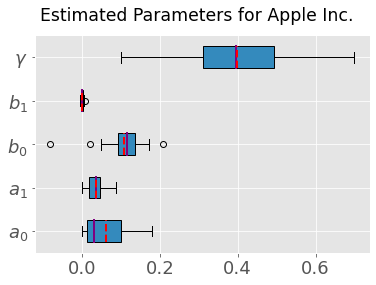

In [42]:
# Load the parameters
list_a0 = list_parameters[0]['a0']
list_a1 = list_parameters[0]['a1']
list_b0 = list_parameters[0]['b0']
list_b1 = list_parameters[0]['b1']
list_gamma = list_parameters[0]['gamma']


# Display the parameters
fig, ax = plt.subplots()
ax.boxplot((list_a0, list_a1, list_b0,list_b1,list_gamma), vert=False, showmeans=True, meanline=True,
           labels=('$a_0$', '$a_1$', '$b_0$','$b_1$','$\gamma$'), patch_artist=True,
           medianprops={'linewidth': 2, 'color': 'purple'},
           meanprops={'linewidth': 2, 'color': 'red'})
fig.suptitle("Estimated Parameters for Apple Inc.",fontsize = 'xx-large')
plt.savefig('eps/fig_parameter_estimation_sp500_single.eps', format='eps')
plt.show()

Display the estimated parameters for all companies.

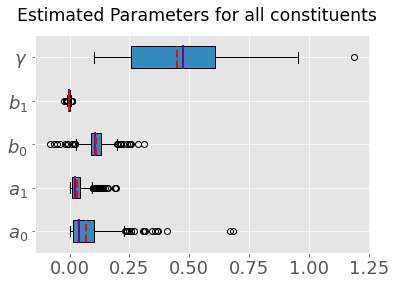

In [44]:
# Load the parameters
list_a0 = []
list_a1 = []
list_b0 = []
list_b1 = []
list_gamma = []
for j in range(20):
    list_a0 += list_parameters[j]['a0'].dropna().tolist()
    list_a1 += list_parameters[j]['a1'].dropna().tolist()
    list_b0 += list_parameters[j]['b0'].dropna().tolist()
    list_b1 += list_parameters[j]['b1'].dropna().tolist()
    list_gamma += list_parameters[j]['gamma'].dropna().tolist()


fig, ax = plt.subplots()
ax.boxplot((list_a0, list_a1, list_b0,list_b1,list_gamma), vert=False, showmeans=True, meanline=True,
           labels=('$a_0$', '$a_1$', '$b_0$','$b_1$','$\gamma$'), patch_artist=True,
           medianprops={'linewidth': 2, 'color': 'purple'},
           meanprops={'linewidth': 2, 'color': 'red'})
fig.suptitle("Estimated Parameters for all constituents",fontsize = 'xx-large')
plt.savefig('eps/fig_parameter_estimation_sp500_all.eps', format='eps')
plt.show()

Compute Hedges and Hedging Errors for all stocks.
Also compute the (relative) hedging errors, when fixing one parameters and choosing the other parameters to be robust. (Sensitivity analysis).

In [11]:
# Create Lists to collect the hedging errors
derivative_payoff = []
error_fix = []
error_robust = []
error_robust_a_0_fix = []
error_robust_a_1_fix = []
error_robust_b_0_fix = []
error_robust_b_1_fix = []
error_robust_gamma_fix = []
epochs = 1000 # Number of epochs for training

for j in range(len(stocks)):
    print("\n\n ############\n \n ##### Calculations for Stock: {} \n".format(str(j+1)))
    # Load Parameters from the List
    list_a0 = list_parameters[j]['a0']
    list_a1 = list_parameters[j]['a1']
    list_b0 = list_parameters[j]['b0']
    list_b1 = list_parameters[j]['b1']
    list_gamma = list_parameters[j]['gamma']
    
    x_0 = stocks[j].iloc[start_index]["CLOSE"].astype('float32')
    T = (30/250)
    n = 30
    def derivative(path):
        return tf.nn.relu(10-tf.math.reduce_mean(path))
    
    #######################################################
    #ROBUST
    # Assign the intervals
    a_0=[np.min(list_a0).astype('float32'),np.max(list_a0).astype('float32')]
    a_1=[np.min(list_a1).astype('float32'),np.max(list_a1).astype('float32')]
    b_0=[np.min(list_b0).astype('float32'),np.max(list_b0).astype('float32')]
    b_1=[np.min(list_b1).astype('float32'),np.max(list_b1).astype('float32')]
    gamma=[np.min(list_gamma).astype('float32'),np.max(list_gamma).astype('float32')]
    # Assign the closing data of the beginning of the test period
    price_robust, hedge_robust = optimal_hedge(derivative,a_0,a_1,b_0,b_1,gamma,x_0,T,n,
                                 depth = 4,nr_neurons = 256,EPOCHS = epochs,l_r = 0.005,BATCH_SIZE =256,scaling_factor=x_0/10.)
    #######################################################
    # NON ROBUST
    a_0_fix=[list_a0[len(list_a0)-1],list_a0[len(list_a0)-1]]
    a_1_fix=[list_a1[len(list_a1)-1],list_a1[len(list_a1)-1]]
    b_0_fix=[list_b0[len(list_b0)-1],list_b0[len(list_b0)-1]]
    b_1_fix=[list_b1[len(list_b1)-1],list_b1[len(list_b1)-1]]  
    gamma_fix=[list_gamma[len(list_gamma)-1],list_gamma[len(list_gamma)-1]]
    price_fix, hedge_fix = optimal_hedge(derivative,a_0_fix,a_1_fix,b_0_fix,b_1_fix,gamma_fix,x_0,T,n,
                             depth = 4,nr_neurons = 256,EPOCHS = epochs,l_r = 0.005,BATCH_SIZE =256,scaling_factor=x_0/10.)
    
    #######################################################
    # a_0 fix, rest robust:
    a_0_a_0_fix=[list_a0[len(list_a0)-1],list_a0[len(list_a0)-1]]
    a_1_a_0_fix=[np.min(list_a1).astype('float32'),np.max(list_a1).astype('float32')]
    b_0_a_0_fix=[np.min(list_b0).astype('float32'),np.max(list_b0).astype('float32')]
    b_1_a_0_fix=[np.min(list_b1).astype('float32'),np.max(list_b1).astype('float32')]
    gamma_a_0_fix=[np.min(list_gamma).astype('float32'),np.max(list_gamma).astype('float32')]
    # Assign the closing data of the beginning of the test period
    price_robust_a_0_fix, hedge_robust_a_0_fix = optimal_hedge(derivative,a_0_a_0_fix,a_1_a_0_fix
                                                               ,b_0_a_0_fix,b_1_a_0_fix,gamma_a_0_fix,x_0,T,n,
                                 depth = 4,nr_neurons = 256,EPOCHS = epochs,l_r = 0.005,BATCH_SIZE =256,scaling_factor=x_0/10.)
       
    #######################################################
    # a_1 fix, rest robust:
    a_0_a_1_fix=[np.min(list_a0).astype('float32'),np.max(list_a0).astype('float32')]
    a_1_a_1_fix=[list_a1[len(list_a1)-1],list_a1[len(list_a1)-1]]
    b_0_a_1_fix=[np.min(list_b0).astype('float32'),np.max(list_b0).astype('float32')]
    b_1_a_1_fix=[np.min(list_b1).astype('float32'),np.max(list_b1).astype('float32')]
    gamma_a_1_fix=[np.min(list_gamma).astype('float32'),np.max(list_gamma).astype('float32')]
    # Assign the closing data of the beginning of the test period
    price_robust_a_1_fix, hedge_robust_a_1_fix = optimal_hedge(derivative,a_0_a_1_fix,a_1_a_1_fix
                                                               ,b_0_a_1_fix,b_1_a_1_fix,gamma_a_1_fix,x_0,T,n,
                                 depth = 4,nr_neurons = 256,EPOCHS = epochs,l_r = 0.005,BATCH_SIZE =256,scaling_factor=x_0/10.)
    
    #######################################################
    # b_0 fix, rest robust:
    a_0_b_0_fix=[np.min(list_a0).astype('float32'),np.max(list_a0).astype('float32')]
    a_1_b_0_fix=[np.min(list_a1).astype('float32'),np.max(list_a1).astype('float32')]
    b_0_b_0_fix=[list_b0[len(list_b0)-1],list_b0[len(list_b0)-1]]
    b_1_b_0_fix=[np.min(list_b1).astype('float32'),np.max(list_b1).astype('float32')]
    gamma_b_0_fix=[np.min(list_gamma).astype('float32'),np.max(list_gamma).astype('float32')]
    # Assign the closing data of the beginning of the test period
    price_robust_b_0_fix, hedge_robust_b_0_fix = optimal_hedge(derivative,a_0_b_0_fix,a_1_b_0_fix
                                                               ,b_0_b_0_fix,b_1_b_0_fix,gamma_b_0_fix,x_0,T,n,
                                 depth = 4,nr_neurons = 256,EPOCHS = epochs,l_r = 0.005,BATCH_SIZE =256,scaling_factor=x_0/10.)
    #######################################################
    # b_1 fix, rest robust:
    a_0_b_1_fix=[np.min(list_a0).astype('float32'),np.max(list_a0).astype('float32')]
    a_1_b_1_fix=[np.min(list_a1).astype('float32'),np.max(list_a1).astype('float32')]
    b_0_b_1_fix=[np.min(list_b0).astype('float32'),np.max(list_b0).astype('float32')]
    b_1_b_1_fix=[list_b1[len(list_b1)-1],list_b1[len(list_b1)-1]]  
    gamma_b_1_fix=[np.min(list_gamma).astype('float32'),np.max(list_gamma).astype('float32')]
    # Assign the closing data of the beginning of the test period
    price_robust_b_1_fix, hedge_robust_b_1_fix = optimal_hedge(derivative,a_0_b_1_fix,a_1_b_1_fix
                                                               ,b_0_b_1_fix,b_1_b_1_fix,gamma_b_1_fix,x_0,T,n,
                                 depth = 4,nr_neurons = 256,EPOCHS = epochs,l_r = 0.005,BATCH_SIZE =256,scaling_factor=x_0/10.)
    #######################################################
    # gamma fix, rest robust:
    a_0_gamma_fix=[np.min(list_a0).astype('float32'),np.max(list_a0).astype('float32')]
    a_1_gamma_fix=[np.min(list_a1).astype('float32'),np.max(list_a1).astype('float32')]
    b_0_gamma_fix=[np.min(list_b0).astype('float32'),np.max(list_b0).astype('float32')]
    b_1_gamma_fix=[np.min(list_b1).astype('float32'),np.max(list_b1).astype('float32')]
    gamma_gamma_fix=[list_gamma[len(list_gamma)-1],list_gamma[len(list_gamma)-1]]
    # Assign the closing data of the beginning of the test period
    price_robust_gamma_fix, hedge_robust_gamma_fix = optimal_hedge(derivative,a_0_gamma_fix,a_1_gamma_fix
                                                               ,b_0_gamma_fix,b_1_gamma_fix,gamma_gamma_fix,x_0,T,n,
                                 depth = 4,nr_neurons = 256,EPOCHS = epochs,l_r = 0.005,BATCH_SIZE =256,scaling_factor=x_0/10.)
    
    ####################################################
    #Evaluate
    t_k = np.linspace(0,T,n+1)
    test_period= np.array(stocks[j].iloc[start_index:end_index]["CLOSE"])/(x_0/10) #Normalize the values of the test period
    
    # Fix Parameters
    hedge_evaluated_fix = [hedge_fix([tf.reshape(test_period[i],(1,1)),tf.reshape(t_k[i],(1,1))]) for i in range(n-1)]
    delta_S_fix = tf.reduce_sum([hedge_evaluated_fix[i]*np.reshape(np.diff(test_period)[i],(1,1)) for i in range(n-1)],0)
    
    # Robust Parameters
    hedge_evaluated_robust = [hedge_robust([tf.reshape(test_period[i],(1,1)),tf.reshape(t_k[i],(1,1))]) for i in range(n-1)]
    delta_S_robust = tf.reduce_sum([hedge_evaluated_robust[i]*np.reshape(np.diff(test_period)[i],(1,1)) for i in range(n-1)],0)
    
    # a_0 fix, rest robust:
    hedge_evaluated_a_0_fix = [hedge_robust_a_0_fix([tf.reshape(test_period[i],(1,1)),tf.reshape(t_k[i],(1,1))]) for i in range(n-1)]
    delta_S_robust_a_0_fix = tf.reduce_sum([hedge_evaluated_a_0_fix[i]*np.reshape(np.diff(test_period)[i],(1,1)) for i in range(n-1)],0)

    # a_1 fix, rest robust:
    hedge_evaluated_a_1_fix = [hedge_robust_a_1_fix([tf.reshape(test_period[i],(1,1)),tf.reshape(t_k[i],(1,1))]) for i in range(n-1)]
    delta_S_robust_a_1_fix = tf.reduce_sum([hedge_evaluated_a_1_fix[i]*np.reshape(np.diff(test_period)[i],(1,1)) for i in range(n-1)],0)
        
    # b_0 fix, rest robust:
    hedge_evaluated_b_0_fix = [hedge_robust_b_0_fix([tf.reshape(test_period[i],(1,1)),tf.reshape(t_k[i],(1,1))]) for i in range(n-1)]
    delta_S_robust_b_0_fix = tf.reduce_sum([hedge_evaluated_b_0_fix[i]*np.reshape(np.diff(test_period)[i],(1,1)) for i in range(n-1)],0)
        
    # b_1 fix, rest robust:
    hedge_evaluated_b_1_fix = [hedge_robust_b_1_fix([tf.reshape(test_period[i],(1,1)),tf.reshape(t_k[i],(1,1))]) for i in range(n-1)]
    delta_S_robust_b_1_fix = tf.reduce_sum([hedge_evaluated_b_1_fix[i]*np.reshape(np.diff(test_period)[i],(1,1)) for i in range(n-1)],0)
        
    # gamma fix, rest robust:
    hedge_evaluated_gamma_fix = [hedge_robust_gamma_fix([tf.reshape(test_period[i],(1,1)),tf.reshape(t_k[i],(1,1))]) for i in range(n-1)]
    delta_S_robust_gamma_fix = tf.reduce_sum([hedge_evaluated_gamma_fix[i]*np.reshape(np.diff(test_period)[i],(1,1)) for i in range(n-1)],0) 
  
    #########################################################
    # Derivative
    derivative_on_batch = derivative(test_period)
    derivative_payoff+= [derivative(test_period)]
    # Compute Hedging Error (Relative), Percentage Values:
    error_fix += [10*(delta_S_fix.numpy()+price_fix - derivative_on_batch.numpy())]
    error_robust += [10*(delta_S_robust.numpy()+price_robust - derivative_on_batch.numpy())]
    error_robust_a_0_fix += [10*(delta_S_robust_a_0_fix.numpy()+price_robust_a_0_fix - derivative_on_batch.numpy())]
    error_robust_a_1_fix += [10*(delta_S_robust_a_1_fix.numpy()+price_robust_a_1_fix - derivative_on_batch.numpy())]
    error_robust_b_0_fix += [10*(delta_S_robust_b_0_fix.numpy()+price_robust_b_0_fix - derivative_on_batch.numpy())]
    error_robust_b_1_fix += [10*(delta_S_robust_b_1_fix.numpy()+price_robust_b_1_fix - derivative_on_batch.numpy())]
    error_robust_gamma_fix += [10*(delta_S_robust_gamma_fix.numpy()+price_robust_gamma_fix - derivative_on_batch.numpy())]



 ############
 
 ##### Calculations for Stock: 1 

tf.Tensor(0.289758, shape=(), dtype=float32)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Iteration:10, Price of Hedge: 0.34066639921185243, Loss: 0.0029711597296306013
Iteration:20, Price of Hedge: 0.1615267907540286, Loss: 0.002426328183362658
Iteration:30, Price of Hedge: 0.2974343832027643, Loss: 0.0022619987094774975
Iteration:40, Price of Hedge: 0.23127552851173336, Loss: 0.002357425956355641
Iteration:50, Price of Hedge: 0.2616092998533276, Loss: 0.002372071228490613
Iteration:60, Price o

Iteration:950, Price of Hedge: 0.2556174480703732, Loss: 0.0015713827769228805
Iteration:960, Price of Hedge: 0.255936383527316, Loss: 0.0015350704538791172
Iteration:970, Price of Hedge: 0.26263754816313567, Loss: 0.0017406429406675583
Iteration:980, Price of Hedge: 0.25493356874609674, Loss: 0.001418428942930028
Iteration:990, Price of Hedge: 0.2509637320639797, Loss: 0.0016191961374113495
tf.Tensor(0.43594366, shape=(), dtype=float32)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Iteration:10, Price of Hedge: 0.5136683840886065, Loss: 0.00671437

Iteration:910, Price of Hedge: 0.41188900499347486, Loss: 0.0038459574568405763
Iteration:920, Price of Hedge: 0.41755631900227286, Loss: 0.004566927343642302
Iteration:930, Price of Hedge: 0.43570519913855604, Loss: 0.005255649046915068
Iteration:940, Price of Hedge: 0.4420870316932053, Loss: 0.003632817251972975
Iteration:950, Price of Hedge: 0.4964163704867701, Loss: 0.00579562581967954
Iteration:960, Price of Hedge: 0.46251669944975904, Loss: 0.003919311635870004
Iteration:970, Price of Hedge: 0.4450358832466805, Loss: 0.004646720081786793
Iteration:980, Price of Hedge: 0.44484634644396126, Loss: 0.004341908165695241
Iteration:990, Price of Hedge: 0.47694494686386973, Loss: 0.004502441047121409
tf.Tensor(0.23284706, shape=(), dtype=float32)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by defaul

Iteration:860, Price of Hedge: 0.2620769446065708, Loss: 0.001432440739553198
Iteration:870, Price of Hedge: 0.24591326788500964, Loss: 0.001554877069904348
Iteration:880, Price of Hedge: 0.24115043063802374, Loss: 0.0016540018500166953
Iteration:890, Price of Hedge: 0.2691840045612139, Loss: 0.0016884547064977661
Iteration:900, Price of Hedge: 0.24460497808156845, Loss: 0.001374127004404946
Iteration:910, Price of Hedge: 0.22096694258167987, Loss: 0.0012747516228519774
Iteration:920, Price of Hedge: 0.2073055929004653, Loss: 0.001251685445121109
Iteration:930, Price of Hedge: 0.2435181037531322, Loss: 0.001298414092573319
Iteration:940, Price of Hedge: 0.23437512206067482, Loss: 0.002183975674551242
Iteration:950, Price of Hedge: 0.2591450735278357, Loss: 0.0016468225254376635
Iteration:960, Price of Hedge: 0.28142003550285893, Loss: 0.001843158102634801
Iteration:970, Price of Hedge: 0.2293159073596854, Loss: 0.0012978992363678389
Iteration:980, Price of Hedge: 0.2173644543012756, Lo

Iteration:820, Price of Hedge: 0.3156940702326068, Loss: 0.0022530332202254756
Iteration:830, Price of Hedge: 0.3105135876740576, Loss: 0.0023250059927047094
Iteration:840, Price of Hedge: 0.3089730991744261, Loss: 0.0021116820005363745
Iteration:850, Price of Hedge: 0.31000932954681276, Loss: 0.002390396700916253
Iteration:860, Price of Hedge: 0.3155163330006559, Loss: 0.0019912883430561303
Iteration:870, Price of Hedge: 0.33830338643141716, Loss: 0.002948945867927688
Iteration:880, Price of Hedge: 0.3106244689346596, Loss: 0.0021604826609817884
Iteration:890, Price of Hedge: 0.30065484798503805, Loss: 0.0017211793038937496
Iteration:900, Price of Hedge: 0.2869037372833361, Loss: 0.002278741945604934
Iteration:910, Price of Hedge: 0.30383835234711115, Loss: 0.002726182296610391
Iteration:920, Price of Hedge: 0.2704625723366064, Loss: 0.0019191137725080188
Iteration:930, Price of Hedge: 0.29521556811804145, Loss: 0.0018741222926928814
Iteration:940, Price of Hedge: 0.3023418891367328, 

Iteration:780, Price of Hedge: 0.26644127366097053, Loss: 0.0014290415459784044
Iteration:790, Price of Hedge: 0.3135053242221318, Loss: 0.0020739614484543757
Iteration:800, Price of Hedge: 0.2718449812925627, Loss: 0.00175200851002284
Iteration:810, Price of Hedge: 0.2981407957409658, Loss: 0.0015907072659879673
Iteration:820, Price of Hedge: 0.2849940907839539, Loss: 0.0015638951389794987
Iteration:830, Price of Hedge: 0.26916744549971555, Loss: 0.0019386816006072172
Iteration:840, Price of Hedge: 0.24034820855986538, Loss: 0.0018385643884373248
Iteration:850, Price of Hedge: 0.2516528914482848, Loss: 0.0016414669363812972
Iteration:860, Price of Hedge: 0.2541966409313915, Loss: 0.0013805357392372764
Iteration:870, Price of Hedge: 0.24452785945833286, Loss: 0.0015012117590826103
Iteration:880, Price of Hedge: 0.23475253480216055, Loss: 0.0016367903339175262
Iteration:890, Price of Hedge: 0.2212026117398608, Loss: 0.0013665252014312347
Iteration:900, Price of Hedge: 0.2850229699855191

Iteration:740, Price of Hedge: 0.24082611596499534, Loss: 0.0016984626899962053
Iteration:750, Price of Hedge: 0.22353168835983014, Loss: 0.0013499816330667658
Iteration:760, Price of Hedge: 0.2186605231207068, Loss: 0.00123561296485889
Iteration:770, Price of Hedge: 0.23629971633563115, Loss: 0.0014279684527925608
Iteration:780, Price of Hedge: 0.22843835146731523, Loss: 0.0017142953171794372
Iteration:790, Price of Hedge: 0.24087323988102582, Loss: 0.001302801748090099
Iteration:800, Price of Hedge: 0.2515527686198539, Loss: 0.0017794453008232126
Iteration:810, Price of Hedge: 0.25407130767549974, Loss: 0.0013551861640677344
Iteration:820, Price of Hedge: 0.24075085651782616, Loss: 0.0012577682431492933
Iteration:830, Price of Hedge: 0.20450944167457977, Loss: 0.0019301861343044902
Iteration:840, Price of Hedge: 0.2180313035727835, Loss: 0.0021541781174748476
Iteration:850, Price of Hedge: 0.24156522521295187, Loss: 0.0016700296906869028
Iteration:860, Price of Hedge: 0.2564318415545

Iteration:700, Price of Hedge: 0.3526845099294974, Loss: 0.0026170126399745366
Iteration:710, Price of Hedge: 0.38243752424596666, Loss: 0.003891775301684408
Iteration:720, Price of Hedge: 0.3608942596036485, Loss: 0.0034517675879970344
Iteration:730, Price of Hedge: 0.3942989931827611, Loss: 0.003358659663261765
Iteration:740, Price of Hedge: 0.35233991784283775, Loss: 0.002615148428639591
Iteration:750, Price of Hedge: 0.35848989874749576, Loss: 0.003395420609363642
Iteration:760, Price of Hedge: 0.369411913623415, Loss: 0.003703016254286329
Iteration:770, Price of Hedge: 0.3768360002809061, Loss: 0.003470218361142985
Iteration:780, Price of Hedge: 0.3876932414626708, Loss: 0.0028380729348851386
Iteration:790, Price of Hedge: 0.38706193963755314, Loss: 0.003605098873464208
Iteration:800, Price of Hedge: 0.4031921759789327, Loss: 0.0032109605192908396
Iteration:810, Price of Hedge: 0.3834435615990344, Loss: 0.0032864678566022045
Iteration:820, Price of Hedge: 0.39369622351300965, Loss

Iteration:650, Price of Hedge: 0.18302778395549238, Loss: 0.0014817671561902833
Iteration:660, Price of Hedge: 0.172797020859241, Loss: 0.001759496147326356
Iteration:670, Price of Hedge: 0.1819612810631952, Loss: 0.001418718224514226
Iteration:680, Price of Hedge: 0.18340490142062435, Loss: 0.0013932715365537083
Iteration:690, Price of Hedge: 0.19823025812382866, Loss: 0.0017956508105232416
Iteration:700, Price of Hedge: 0.20450299920097448, Loss: 0.0014988039810710063
Iteration:710, Price of Hedge: 0.20351510686791696, Loss: 0.001588001856439547
Iteration:720, Price of Hedge: 0.2050083006936461, Loss: 0.0015774470886802837
Iteration:730, Price of Hedge: 0.21269840249815386, Loss: 0.002264269523522877
Iteration:740, Price of Hedge: 0.22160041709094003, Loss: 0.0018940398194324359
Iteration:750, Price of Hedge: 0.20703698336456, Loss: 0.0016263858089778259
Iteration:760, Price of Hedge: 0.18067475557602392, Loss: 0.001733365724423308
Iteration:770, Price of Hedge: 0.1797840322907632, L

Iteration:600, Price of Hedge: 0.1737350451448151, Loss: 0.0017391065116054705
Iteration:610, Price of Hedge: 0.17573474683510995, Loss: 0.0016437152404135346
Iteration:620, Price of Hedge: 0.18709538943083998, Loss: 0.002036401346899197
Iteration:630, Price of Hedge: 0.197376637788102, Loss: 0.0013987930332053367
Iteration:640, Price of Hedge: 0.19313538489790288, Loss: 0.0018488385725248689
Iteration:650, Price of Hedge: 0.18310229846132414, Loss: 0.001769773760786908
Iteration:660, Price of Hedge: 0.18193241230321744, Loss: 0.0018465779403090464
Iteration:670, Price of Hedge: 0.18765501974148718, Loss: 0.0016558866867867116
Iteration:680, Price of Hedge: 0.20921866485232385, Loss: 0.001669025159467452
Iteration:690, Price of Hedge: 0.221578449900403, Loss: 0.0014919976457487215
Iteration:700, Price of Hedge: 0.1983994026854475, Loss: 0.0020546010362574307
Iteration:710, Price of Hedge: 0.19688850605355127, Loss: 0.0019379288300518382
Iteration:720, Price of Hedge: 0.1988153625200538

Iteration:550, Price of Hedge: 0.18356154740831698, Loss: 0.0013834060928509472
Iteration:560, Price of Hedge: 0.17150864373148805, Loss: 0.0016416031032846056
Iteration:570, Price of Hedge: 0.20819877560891198, Loss: 0.0014327004342237436
Iteration:580, Price of Hedge: 0.18008754704277408, Loss: 0.001547355299056985
Iteration:590, Price of Hedge: 0.17957932781342834, Loss: 0.0018549423233437778
Iteration:600, Price of Hedge: 0.18502692454258066, Loss: 0.0014522478671824322
Iteration:610, Price of Hedge: 0.19546640400409387, Loss: 0.001779919317731071
Iteration:620, Price of Hedge: 0.19077044710287508, Loss: 0.0015515452714977228
Iteration:630, Price of Hedge: 0.18040845599418842, Loss: 0.0014723474169291428
Iteration:640, Price of Hedge: 0.17554150289076914, Loss: 0.0014133863193757533
Iteration:650, Price of Hedge: 0.19062220363570076, Loss: 0.0014172490546729753
Iteration:660, Price of Hedge: 0.19786793975576983, Loss: 0.0018653084859041158
Iteration:670, Price of Hedge: 0.170823803

Iteration:500, Price of Hedge: 0.18141541180868898, Loss: 0.0021580818375852573
Iteration:510, Price of Hedge: 0.16778875391324846, Loss: 0.0015667428395198966
Iteration:520, Price of Hedge: 0.16310860609487463, Loss: 0.0019032644876569192
Iteration:530, Price of Hedge: 0.16967305070153316, Loss: 0.001105995023668438
Iteration:540, Price of Hedge: 0.16329607067618782, Loss: 0.0013553267130288482
Iteration:550, Price of Hedge: 0.18829944677422644, Loss: 0.0018007044654583025
Iteration:560, Price of Hedge: 0.18035596478921434, Loss: 0.00153908088979815
Iteration:570, Price of Hedge: 0.20855011038170232, Loss: 0.0016714566432260547
Iteration:580, Price of Hedge: 0.18460334773194517, Loss: 0.001426948249632698
Iteration:590, Price of Hedge: 0.18129819734883768, Loss: 0.0012307520476197097
Iteration:600, Price of Hedge: 0.16718075650619538, Loss: 0.0014152873852594004
Iteration:610, Price of Hedge: 0.1917321499437662, Loss: 0.0014414007120491235
Iteration:620, Price of Hedge: 0.169193616066

Iteration:450, Price of Hedge: 0.1936689098818647, Loss: 0.0025442462151993085
Iteration:460, Price of Hedge: 0.2037276808177239, Loss: 0.0019905381735526363
Iteration:470, Price of Hedge: 0.19563206972583203, Loss: 0.001299955580092771
Iteration:480, Price of Hedge: 0.22125507209487977, Loss: 0.002295616781570864
Iteration:490, Price of Hedge: 0.1913603629590966, Loss: 0.0023682454545943085
Iteration:500, Price of Hedge: 0.206261202071164, Loss: 0.001826836860989811
Iteration:510, Price of Hedge: 0.20403113945941412, Loss: 0.0020270846226798866
Iteration:520, Price of Hedge: 0.19578663963166035, Loss: 0.002322120140843431
Iteration:530, Price of Hedge: 0.18875788212156974, Loss: 0.001236038472713119
Iteration:540, Price of Hedge: 0.19058198656337025, Loss: 0.0016079957609731466
Iteration:550, Price of Hedge: 0.1978797930610085, Loss: 0.0015116667241291458
Iteration:560, Price of Hedge: 0.20746026559601205, Loss: 0.0014872814198708894
Iteration:570, Price of Hedge: 0.18813183121884547,

Iteration:400, Price of Hedge: 0.18647193363044606, Loss: 0.0022275255923686287
Iteration:410, Price of Hedge: 0.2010270069190483, Loss: 0.002450309867087519
Iteration:420, Price of Hedge: 0.21275789346562987, Loss: 0.0021740454429929556
Iteration:430, Price of Hedge: 0.2310493950894852, Loss: 0.002572616996081223
Iteration:440, Price of Hedge: 0.20971504480401107, Loss: 0.0024127597884357143
Iteration:450, Price of Hedge: 0.20994065037579046, Loss: 0.0020043419699769414
Iteration:460, Price of Hedge: 0.20507134063890362, Loss: 0.0026995030340938087
Iteration:470, Price of Hedge: 0.17319982282365345, Loss: 0.0021100426358657384
Iteration:480, Price of Hedge: 0.14549114372548502, Loss: 0.0027638096260039543
Iteration:490, Price of Hedge: 0.16965191113822584, Loss: 0.0025606964022939493
Iteration:500, Price of Hedge: 0.1851752381476558, Loss: 0.002276375544385445
Iteration:510, Price of Hedge: 0.173465785743565, Loss: 0.002361691286943568
Iteration:520, Price of Hedge: 0.1805133822938159

Iteration:350, Price of Hedge: 0.1933020044950922, Loss: 0.0026783547035488906
Iteration:360, Price of Hedge: 0.17354666877079125, Loss: 0.002251773579767935
Iteration:370, Price of Hedge: 0.18615014094148136, Loss: 0.0018738732003180658
Iteration:380, Price of Hedge: 0.18588083945749076, Loss: 0.0020175342515784678
Iteration:390, Price of Hedge: 0.20278561658906255, Loss: 0.0016971294163262483
Iteration:400, Price of Hedge: 0.20136664268998172, Loss: 0.0024963597825950145
Iteration:410, Price of Hedge: 0.21494901551484416, Loss: 0.0021828854486676263
Iteration:420, Price of Hedge: 0.20659807440880512, Loss: 0.002163056368200955
Iteration:430, Price of Hedge: 0.19357993294088371, Loss: 0.001529841207679272
Iteration:440, Price of Hedge: 0.18652509815926804, Loss: 0.002392378152819141
Iteration:450, Price of Hedge: 0.1608712631690196, Loss: 0.0015850052146269887
Iteration:460, Price of Hedge: 0.17212330423911906, Loss: 0.0016216481033678675
Iteration:470, Price of Hedge: 0.1808327482114

Iteration:300, Price of Hedge: 1.8634056379318509, Loss: 0.01762823961651758
Iteration:310, Price of Hedge: 1.7307886755841422, Loss: 0.013872326457147732
Iteration:320, Price of Hedge: 1.620023193629288, Loss: 0.015422939369946676
Iteration:330, Price of Hedge: 1.773790336412037, Loss: 0.01673486221348659
Iteration:340, Price of Hedge: 1.653704876514712, Loss: 0.016528457337579284
Iteration:350, Price of Hedge: 1.7748810238643613, Loss: 0.01381677097997045
Iteration:360, Price of Hedge: 1.8828683048624726, Loss: 0.01656171070679786
Iteration:370, Price of Hedge: 1.653488885518618, Loss: 0.014876361514330404
Iteration:380, Price of Hedge: 1.8003414656135306, Loss: 0.013596252222312621
Iteration:390, Price of Hedge: 1.6722031302321851, Loss: 0.017564923011011136
Iteration:400, Price of Hedge: 1.894484193307676, Loss: 0.015014019353109998
Iteration:410, Price of Hedge: 1.646587738420601, Loss: 0.013067831267019424
Iteration:420, Price of Hedge: 1.4976894485730894, Loss: 0.014565653047808

Iteration:270, Price of Hedge: 1.8835421028611563, Loss: 0.022676853594639113
Iteration:280, Price of Hedge: 1.730444062620654, Loss: 0.01963899415896302
Iteration:290, Price of Hedge: 2.0599715307464748, Loss: 0.01985852901935967
Iteration:300, Price of Hedge: 2.277339134050578, Loss: 0.018240767411188852
Iteration:310, Price of Hedge: 1.983377903790074, Loss: 0.019945484051342
Iteration:320, Price of Hedge: 2.08211463252303, Loss: 0.02167574795726468
Iteration:330, Price of Hedge: 1.9907633536805747, Loss: 0.01960311138654447
Iteration:340, Price of Hedge: 2.0037701034003135, Loss: 0.021863347425333222
Iteration:350, Price of Hedge: 2.1396691897973596, Loss: 0.023461788750001312
Iteration:360, Price of Hedge: 2.2837465874432383, Loss: 0.023241694469990113
Iteration:370, Price of Hedge: 2.207024506214316, Loss: 0.023310923629876967
Iteration:380, Price of Hedge: 2.003534324409236, Loss: 0.020133056006970483
Iteration:390, Price of Hedge: 1.7583228321296587, Loss: 0.017603984125314654


Iteration:250, Price of Hedge: 1.6675408773801677, Loss: 0.015812660944086596
Iteration:260, Price of Hedge: 1.511272565570448, Loss: 0.015701289276609565
Iteration:270, Price of Hedge: 1.841065326984949, Loss: 0.01484737650366963
Iteration:280, Price of Hedge: 1.617808112055218, Loss: 0.01628138514491546
Iteration:290, Price of Hedge: 1.60541814407743, Loss: 0.016291465178906783
Iteration:300, Price of Hedge: 1.812322761186442, Loss: 0.015779672218339067
Iteration:310, Price of Hedge: 1.8685615844892254, Loss: 0.015801544608186367
Iteration:320, Price of Hedge: 1.7661293638456186, Loss: 0.017386371205373584
Iteration:330, Price of Hedge: 1.7670642627611641, Loss: 0.013529821470614678
Iteration:340, Price of Hedge: 1.785948046991075, Loss: 0.014574374491307829
Iteration:350, Price of Hedge: 1.6130777750848664, Loss: 0.01939278664298678
Iteration:360, Price of Hedge: 1.6597922003953045, Loss: 0.013841741794614925
Iteration:370, Price of Hedge: 1.4487200303088683, Loss: 0.017926784964300

Iteration:230, Price of Hedge: 1.6054570492879066, Loss: 0.01490044144996343
Iteration:240, Price of Hedge: 1.5722504459769653, Loss: 0.01425942517866865
Iteration:250, Price of Hedge: 1.5538310088496814, Loss: 0.01484438026793553
Iteration:260, Price of Hedge: 1.8991863575394063, Loss: 0.015070954382638835
Iteration:270, Price of Hedge: 1.7460061468112598, Loss: 0.014081436722994223
Iteration:280, Price of Hedge: 1.627353471906656, Loss: 0.014981990942532164
Iteration:290, Price of Hedge: 1.5959532777649088, Loss: 0.010582220524902342
Iteration:300, Price of Hedge: 1.6226576800800898, Loss: 0.014706156458960428
Iteration:310, Price of Hedge: 1.6167038413182013, Loss: 0.014331193343738136
Iteration:320, Price of Hedge: 1.5105107277635739, Loss: 0.014903404932792696
Iteration:330, Price of Hedge: 1.7715380265762177, Loss: 0.018248334642321406
Iteration:340, Price of Hedge: 1.604679112773249, Loss: 0.014660137317554245
Iteration:350, Price of Hedge: 1.6874928779494553, Loss: 0.0148170512

Iteration:200, Price of Hedge: 1.77791076713022, Loss: 0.01690464148109374
Iteration:210, Price of Hedge: 1.85850358141181, Loss: 0.015390917509949809
Iteration:220, Price of Hedge: 1.7079838498397406, Loss: 0.014587670860553724
Iteration:230, Price of Hedge: 1.6950029251304044, Loss: 0.014715352164521267
Iteration:240, Price of Hedge: 1.9098695271024098, Loss: 0.019279648938881167
Iteration:250, Price of Hedge: 1.7598114595150036, Loss: 0.01644524530756124
Iteration:260, Price of Hedge: 1.701606246134429, Loss: 0.012386783085321883
Iteration:270, Price of Hedge: 1.6333978658998263, Loss: 0.019104068476770042
Iteration:280, Price of Hedge: 1.620841376913404, Loss: 0.01523506215724515
Iteration:290, Price of Hedge: 1.945190091979157, Loss: 0.01632683176554517
Iteration:300, Price of Hedge: 2.146791694127398, Loss: 0.015985209797326403
Iteration:310, Price of Hedge: 1.98302742150604, Loss: 0.015714115314142064
Iteration:320, Price of Hedge: 1.9991259615945522, Loss: 0.01719602835399625
I

Iteration:180, Price of Hedge: 1.2347512666855323, Loss: 0.014191825803326273
Iteration:190, Price of Hedge: 1.3845515034060951, Loss: 0.018282527364850587
Iteration:200, Price of Hedge: 1.6360201106249177, Loss: 0.017072728078579135
Iteration:210, Price of Hedge: 1.9211002204249212, Loss: 0.015621605389500104
Iteration:220, Price of Hedge: 1.7870241449894706, Loss: 0.01395593283213996
Iteration:230, Price of Hedge: 1.5952620394994597, Loss: 0.01454973906640884
Iteration:240, Price of Hedge: 1.478761057507029, Loss: 0.013571514608350554
Iteration:250, Price of Hedge: 1.5373254733050203, Loss: 0.01696287221553776
Iteration:260, Price of Hedge: 1.6629133373668081, Loss: 0.016003044409065924
Iteration:270, Price of Hedge: 1.5678073703236237, Loss: 0.015433759619587217
Iteration:280, Price of Hedge: 1.5781117171690993, Loss: 0.01538871258439647
Iteration:290, Price of Hedge: 1.697513317375376, Loss: 0.017049863930773502
Iteration:300, Price of Hedge: 1.7824410441173881, Loss: 0.01544474232

Iteration:150, Price of Hedge: 2.1667359807325397, Loss: 0.023323016002341213
Iteration:160, Price of Hedge: 2.4769931279467756, Loss: 0.02286574090692568
Iteration:170, Price of Hedge: 2.193737706057095, Loss: 0.026978523166772028
Iteration:180, Price of Hedge: 2.296064782015492, Loss: 0.025963539468561867
Iteration:190, Price of Hedge: 2.2334178345405573, Loss: 0.025647662593657826
Iteration:200, Price of Hedge: 1.928557443720956, Loss: 0.022561898759373377
Iteration:210, Price of Hedge: 2.143067861783254, Loss: 0.02324517675883193
Iteration:220, Price of Hedge: 2.052954338796519, Loss: 0.02160862939456525
Iteration:230, Price of Hedge: 2.1317420854678972, Loss: 0.0221346698687352
Iteration:240, Price of Hedge: 2.1442434028411865, Loss: 0.020479759915903093
Iteration:250, Price of Hedge: 2.216960092034628, Loss: 0.022829673408123873
Iteration:260, Price of Hedge: 2.0435505134176766, Loss: 0.020384993971176258
Iteration:270, Price of Hedge: 1.9419436869377136, Loss: 0.0239142006941072

Iteration:120, Price of Hedge: 1.093827820200022, Loss: 0.009877202493334635
Iteration:130, Price of Hedge: 1.0533896845238815, Loss: 0.008749046190767018
Iteration:140, Price of Hedge: 1.1153305116680712, Loss: 0.00740608157678011
Iteration:150, Price of Hedge: 1.166235900837455, Loss: 0.008552680981455296
Iteration:160, Price of Hedge: 1.082803139005955, Loss: 0.006997840959547474
Iteration:170, Price of Hedge: 1.199626759919738, Loss: 0.007646275359981303
Iteration:180, Price of Hedge: 1.201693533802154, Loss: 0.007776696018819962
Iteration:190, Price of Hedge: 1.2713893204835585, Loss: 0.007857373643570042
Iteration:200, Price of Hedge: 0.9988247253178087, Loss: 0.00771623335734688
Iteration:210, Price of Hedge: 1.012327882023419, Loss: 0.007722682118168222
Iteration:220, Price of Hedge: 0.9000693822406447, Loss: 0.008202008160155571
Iteration:230, Price of Hedge: 0.989833755059044, Loss: 0.009782871010796156
Iteration:240, Price of Hedge: 1.113822977154814, Loss: 0.009012958852418

Iteration:90, Price of Hedge: 1.7141752152150729, Loss: 0.01989183701426924
Iteration:100, Price of Hedge: 1.757001129756736, Loss: 0.02314994559402095
Iteration:110, Price of Hedge: 1.8235985106682164, Loss: 0.02265763533923035
Iteration:120, Price of Hedge: 1.8276917488125946, Loss: 0.025507764702136625
Iteration:130, Price of Hedge: 1.6294138211183962, Loss: 0.017958799285281657
Iteration:140, Price of Hedge: 1.744814942701396, Loss: 0.021991242157203317
Iteration:150, Price of Hedge: 1.68417466696319, Loss: 0.01809008685572593
Iteration:160, Price of Hedge: 1.7910249404635579, Loss: 0.023023162425511143
Iteration:170, Price of Hedge: 1.5909722571766904, Loss: 0.023883460734018057
Iteration:180, Price of Hedge: 1.6493577984427246, Loss: 0.0255087395353911
Iteration:190, Price of Hedge: 1.5970787117583312, Loss: 0.01888402042701216
Iteration:200, Price of Hedge: 1.538986887221108, Loss: 0.022926698163502124
Iteration:210, Price of Hedge: 1.7912901234160925, Loss: 0.020863395465923418

Iteration:60, Price of Hedge: 1.071720597654439, Loss: 0.009832041706304294
Iteration:70, Price of Hedge: 0.9807536733640517, Loss: 0.00989015574500911
Iteration:80, Price of Hedge: 1.0616838418492989, Loss: 0.009879151275239905
Iteration:90, Price of Hedge: 1.0126479811723583, Loss: 0.007890982391153755
Iteration:100, Price of Hedge: 0.8768939547530408, Loss: 0.009361259166650626
Iteration:110, Price of Hedge: 0.9591135215610848, Loss: 0.009628451938744575
Iteration:120, Price of Hedge: 1.0934284605614266, Loss: 0.010005836252741318
Iteration:130, Price of Hedge: 1.1590793579971432, Loss: 0.008111432704838962
Iteration:140, Price of Hedge: 1.0945301813676451, Loss: 0.008405112280295413
Iteration:150, Price of Hedge: 1.1270809924888454, Loss: 0.008588426931527948
Iteration:160, Price of Hedge: 1.05513420790121, Loss: 0.010172872427069279
Iteration:170, Price of Hedge: 1.038104978469346, Loss: 0.010235354638741966
Iteration:180, Price of Hedge: 1.027312643739242, Loss: 0.008608929391000

Iteration:30, Price of Hedge: 1.4001317941439992, Loss: 0.011107134218401172
Iteration:40, Price of Hedge: 1.0046243285752097, Loss: 0.01493272932741263
Iteration:50, Price of Hedge: 1.2398755762548717, Loss: 0.010709482749510358
Iteration:60, Price of Hedge: 1.1303964587711561, Loss: 0.010543627521094123
Iteration:70, Price of Hedge: 1.2075557528463832, Loss: 0.009806397930248067
Iteration:80, Price of Hedge: 1.1645938499503246, Loss: 0.010491089139379283
Iteration:90, Price of Hedge: 1.1706355373889892, Loss: 0.010348627255259401
Iteration:100, Price of Hedge: 1.1379394531131766, Loss: 0.009984404074801745
Iteration:110, Price of Hedge: 1.0628661818964247, Loss: 0.012229449482875054
Iteration:120, Price of Hedge: 1.1019759117659305, Loss: 0.010166323706032187
Iteration:130, Price of Hedge: 1.0539785899620255, Loss: 0.011186801625749608
Iteration:140, Price of Hedge: 1.0228015895851057, Loss: 0.009363795325398883
Iteration:150, Price of Hedge: 1.2822936389626192, Loss: 0.0099289615392

Iteration:10, Price of Hedge: 0.5485489407723435, Loss: 0.015986904455081684
Iteration:20, Price of Hedge: 1.2979499634843705, Loss: 0.008467228266044912
Iteration:30, Price of Hedge: 0.9771738167341026, Loss: 0.011808638205059195
Iteration:40, Price of Hedge: 1.0044594667567253, Loss: 0.007756709283292196
Iteration:50, Price of Hedge: 1.2083808545437023, Loss: 0.009518260396841782
Iteration:60, Price of Hedge: 0.9413348275848875, Loss: 0.0091623002993515
Iteration:70, Price of Hedge: 1.0948429206139736, Loss: 0.009167587575542058
Iteration:80, Price of Hedge: 1.0184732874742621, Loss: 0.008324240927339587
Iteration:90, Price of Hedge: 1.006247243715552, Loss: 0.009156592836413324
Iteration:100, Price of Hedge: 1.0655814198134976, Loss: 0.00869489871495972
Iteration:110, Price of Hedge: 1.0166026266891095, Loss: 0.008193072778392008
Iteration:120, Price of Hedge: 0.9330562958988593, Loss: 0.008492227166019006
Iteration:130, Price of Hedge: 1.0531811162068152, Loss: 0.007948992046624425

Iteration:10, Price of Hedge: 0.8535313026659423, Loss: 0.010511844595504272
Iteration:20, Price of Hedge: 1.0288707917366082, Loss: 0.00882080435661976
Iteration:30, Price of Hedge: 1.088660375962263, Loss: 0.008996546800358373
Iteration:40, Price of Hedge: 1.0402977765303147, Loss: 0.008909425722409025
Iteration:50, Price of Hedge: 1.1287904147921834, Loss: 0.013339586408497438
Iteration:60, Price of Hedge: 1.067272272516402, Loss: 0.009743784797230858
Iteration:70, Price of Hedge: 1.1422632260531826, Loss: 0.007602951894792653
Iteration:80, Price of Hedge: 1.1559707615928345, Loss: 0.011517907013665507
Iteration:90, Price of Hedge: 1.1106262883777163, Loss: 0.00816728569653975
Iteration:100, Price of Hedge: 1.0597948379222544, Loss: 0.008472925113738938
Iteration:110, Price of Hedge: 0.9783166397656714, Loss: 0.00890520262444454
Iteration:120, Price of Hedge: 0.9982528042703052, Loss: 0.00929400717193971
Iteration:130, Price of Hedge: 1.0384899579905322, Loss: 0.010078524137060896
I

Iteration:10, Price of Hedge: 1.2500140119453136, Loss: 0.014326299890383608
Iteration:20, Price of Hedge: 1.5359942375902391, Loss: 0.01962256719273654
Iteration:30, Price of Hedge: 1.866364187237741, Loss: 0.01860000780056197
Iteration:40, Price of Hedge: 1.6616422685052383, Loss: 0.017613892310762935
Iteration:50, Price of Hedge: 1.4581694950897144, Loss: 0.01673069515141634
Iteration:60, Price of Hedge: 1.286930151148954, Loss: 0.021096840607656018
Iteration:70, Price of Hedge: 1.43463999967189, Loss: 0.019120899600227403
Iteration:80, Price of Hedge: 1.5381404984208529, Loss: 0.017154211547283183
Iteration:90, Price of Hedge: 1.6319350972943538, Loss: 0.020871820431364086
Iteration:100, Price of Hedge: 1.6187844233091708, Loss: 0.01720634654972031
Iteration:110, Price of Hedge: 1.5838955409723894, Loss: 0.018306855448898318
Iteration:120, Price of Hedge: 1.3724661466881116, Loss: 0.017180505507043618
Iteration:130, Price of Hedge: 1.3104548909373988, Loss: 0.016049985543445187
Ite

Iteration:10, Price of Hedge: 0.09077539979086283, Loss: 0.000979447644817899
Iteration:20, Price of Hedge: 0.1550001725254333, Loss: 0.0013628479106455593
Iteration:30, Price of Hedge: 0.17569778721374404, Loss: 0.001056567162023292
Iteration:40, Price of Hedge: 0.137574479327742, Loss: 0.0011782114658930533
Iteration:50, Price of Hedge: 0.1360439877036697, Loss: 0.0011005436374119883
Iteration:60, Price of Hedge: 0.15530572945258428, Loss: 0.001160330855327052
Iteration:70, Price of Hedge: 0.14285939287505017, Loss: 0.0008881308423048129
Iteration:80, Price of Hedge: 0.13500928863425088, Loss: 0.0009754410519815072
Iteration:90, Price of Hedge: 0.12196470763856837, Loss: 0.0010730732003446431
Iteration:100, Price of Hedge: 0.12370721670311582, Loss: 0.0012292794525165186
Iteration:110, Price of Hedge: 0.12523483945917066, Loss: 0.0008542518942475486
Iteration:120, Price of Hedge: 0.13950835717769225, Loss: 0.001161019616915393
Iteration:130, Price of Hedge: 0.14767169863807794, Loss:

Iteration:10, Price of Hedge: 0.1545859583462857, Loss: 0.002639712125823124
Iteration:20, Price of Hedge: 0.19148639999820036, Loss: 0.0013424732706904586
Iteration:30, Price of Hedge: 0.17457828116813517, Loss: 0.0015257584696134253
Iteration:40, Price of Hedge: 0.17471461984883946, Loss: 0.0014578082008345206
Iteration:50, Price of Hedge: 0.16376424955268476, Loss: 0.0015730170840246415
Iteration:60, Price of Hedge: 0.17577459013809857, Loss: 0.0016804780843837186
Iteration:70, Price of Hedge: 0.15919733542829137, Loss: 0.001470212513891589
Iteration:80, Price of Hedge: 0.1601260932273476, Loss: 0.0012592818595276612
Iteration:90, Price of Hedge: 0.1623460035139601, Loss: 0.0016315547227446993
Iteration:100, Price of Hedge: 0.18245680428960895, Loss: 0.001443522176785006
Iteration:110, Price of Hedge: 0.16136440098615595, Loss: 0.0013948760622364276
Iteration:120, Price of Hedge: 0.1642216856117443, Loss: 0.0016431257488041418
Iteration:130, Price of Hedge: 0.1595212926813474, Loss:

Iteration:10, Price of Hedge: 0.11719158575626808, Loss: 0.0015589639025645142
Iteration:20, Price of Hedge: 0.11588207790939009, Loss: 0.0008917876794351187
Iteration:30, Price of Hedge: 0.1777798299558185, Loss: 0.0012858163593188366
Iteration:40, Price of Hedge: 0.1326093681211887, Loss: 0.000957859750235901
Iteration:50, Price of Hedge: 0.15587943110954258, Loss: 0.000952398137126842
Iteration:60, Price of Hedge: 0.1373525602456141, Loss: 0.0009454232579676259
Iteration:70, Price of Hedge: 0.1385296864711222, Loss: 0.0014679117705505896
Iteration:80, Price of Hedge: 0.1412330235019681, Loss: 0.0008626348598080646
Iteration:90, Price of Hedge: 0.13125338281376459, Loss: 0.0009927114519594493
Iteration:100, Price of Hedge: 0.14367258655490786, Loss: 0.0009807693110668314
Iteration:110, Price of Hedge: 0.1382595901915977, Loss: 0.0008692565405071573
Iteration:120, Price of Hedge: 0.15965468155418422, Loss: 0.0010372927981544323
Iteration:130, Price of Hedge: 0.1535836352168758, Loss: 

Iteration:10, Price of Hedge: 0.08853989509314601, Loss: 0.002242542811133852
Iteration:20, Price of Hedge: 0.16710961946054112, Loss: 0.0011474041570400217
Iteration:30, Price of Hedge: 0.16231145119131726, Loss: 0.001094063671710721
Iteration:40, Price of Hedge: 0.14618177586550019, Loss: 0.001198718616748451
Iteration:50, Price of Hedge: 0.14353314517995272, Loss: 0.0010851008480059043
Iteration:60, Price of Hedge: 0.14302540050744597, Loss: 0.0011104308054457057
Iteration:70, Price of Hedge: 0.14689200506281283, Loss: 0.0011857724563620665
Iteration:80, Price of Hedge: 0.13284516389093712, Loss: 0.0010617156250355198
Iteration:90, Price of Hedge: 0.1357477388592713, Loss: 0.0011745440194594892
Iteration:100, Price of Hedge: 0.141923755188742, Loss: 0.0008391574553418213
Iteration:110, Price of Hedge: 0.12686271071613647, Loss: 0.0008973725993469462
Iteration:120, Price of Hedge: 0.13403227269794799, Loss: 0.001115360477925842
Iteration:130, Price of Hedge: 0.13029004571211544, Loss

Iteration:10, Price of Hedge: 0.09494398193334633, Loss: 0.0010495759122173265
Iteration:20, Price of Hedge: 0.15562702468390627, Loss: 0.0010373712086341415
Iteration:30, Price of Hedge: 0.1611365463150264, Loss: 0.0010769139086446611
Iteration:40, Price of Hedge: 0.14463313572838957, Loss: 0.001155841855363704
Iteration:50, Price of Hedge: 0.12742119568129057, Loss: 0.0009017188304081714
Iteration:60, Price of Hedge: 0.1340777968669272, Loss: 0.0009715129398851108
Iteration:70, Price of Hedge: 0.15164564742120776, Loss: 0.0011243537243347036
Iteration:80, Price of Hedge: 0.1443358256726242, Loss: 0.0010386756611128866
Iteration:90, Price of Hedge: 0.13325185965734931, Loss: 0.0011421311225398689
Iteration:100, Price of Hedge: 0.14505716161602322, Loss: 0.0010595615149123995
Iteration:110, Price of Hedge: 0.15388656609555937, Loss: 0.0010734015266633534
Iteration:120, Price of Hedge: 0.134205097264379, Loss: 0.0011812880233173396
Iteration:130, Price of Hedge: 0.14312135919630578, Los

Iteration:10, Price of Hedge: 0.06027602772140597, Loss: 0.0023778846388935906
Iteration:20, Price of Hedge: 0.17912413294488944, Loss: 0.001044139522551113
Iteration:30, Price of Hedge: 0.1309108363751534, Loss: 0.0010317356310557636
Iteration:40, Price of Hedge: 0.14566664768000806, Loss: 0.0009769899399969084
Iteration:50, Price of Hedge: 0.15565630692298102, Loss: 0.0009862881863093697
Iteration:60, Price of Hedge: 0.13739857005369346, Loss: 0.0009325744783382995
Iteration:70, Price of Hedge: 0.14232429952655254, Loss: 0.0009425727981452249
Iteration:80, Price of Hedge: 0.1406738460514305, Loss: 0.0008414280570199217
Iteration:90, Price of Hedge: 0.14392595526542779, Loss: 0.001073637671486205
Iteration:100, Price of Hedge: 0.1437984480216926, Loss: 0.0010824473277665004
Iteration:110, Price of Hedge: 0.15709311516731078, Loss: 0.001003018987287163
Iteration:120, Price of Hedge: 0.159115118527302, Loss: 0.0009165974999741256
Iteration:130, Price of Hedge: 0.15433959542945105, Loss:

Iteration:10, Price of Hedge: 0.13574011252673587, Loss: 0.0014443690942782083
Iteration:20, Price of Hedge: 0.13252799659196626, Loss: 0.0020361135928039786
Iteration:30, Price of Hedge: 0.18984470601351405, Loss: 0.0014999215139464006
Iteration:40, Price of Hedge: 0.1600468441208591, Loss: 0.0011951470053456427
Iteration:50, Price of Hedge: 0.13626563698629754, Loss: 0.0013988200531575678
Iteration:60, Price of Hedge: 0.17075792024708109, Loss: 0.0013470051996888443
Iteration:70, Price of Hedge: 0.17202723696176464, Loss: 0.0013869727636516948
Iteration:80, Price of Hedge: 0.16785664031634726, Loss: 0.0014426680927425827
Iteration:90, Price of Hedge: 0.1646139920714859, Loss: 0.0014903198837169286
Iteration:100, Price of Hedge: 0.18175095483751422, Loss: 0.001301433675276531
Iteration:110, Price of Hedge: 0.16479234752766844, Loss: 0.0012218020717884137
Iteration:120, Price of Hedge: 0.1750607006609016, Loss: 0.0018616109296907268
Iteration:130, Price of Hedge: 0.14773431910204524, L

Iteration:10, Price of Hedge: 0.1716268734475193, Loss: 0.0036089022804489447
Iteration:20, Price of Hedge: 0.16116586462545684, Loss: 0.0029266855363804466
Iteration:30, Price of Hedge: 0.16807418570973595, Loss: 0.002805998532773657
Iteration:40, Price of Hedge: 0.17551921110987223, Loss: 0.0024958050046295813
Iteration:50, Price of Hedge: 0.16335100672280306, Loss: 0.0033143097618429707
Iteration:60, Price of Hedge: 0.1736146826806703, Loss: 0.002506171321785189
Iteration:70, Price of Hedge: 0.1779304732082437, Loss: 0.0028374007042522467
Iteration:80, Price of Hedge: 0.15897433505579103, Loss: 0.002791167946817019
Iteration:90, Price of Hedge: 0.16192324131608302, Loss: 0.002966299123334615
Iteration:100, Price of Hedge: 0.1653410611437721, Loss: 0.002423710979518212
Iteration:110, Price of Hedge: 0.18580544337326046, Loss: 0.00328992489008062
Iteration:120, Price of Hedge: 0.15505935406513346, Loss: 0.002678730431153653
Iteration:130, Price of Hedge: 0.17291481064547726, Loss: 0.0

Iteration:10, Price of Hedge: 0.13151384315788164, Loss: 0.0015661857500104404
Iteration:20, Price of Hedge: 0.07034903990256396, Loss: 0.0012880476081146952
Iteration:30, Price of Hedge: 0.1315325530563655, Loss: 0.0013243567768061128
Iteration:40, Price of Hedge: 0.10348801644829564, Loss: 0.0011702004026898471
Iteration:50, Price of Hedge: 0.1098206209028092, Loss: 0.0012505358933317724
Iteration:60, Price of Hedge: 0.11071433618857328, Loss: 0.0010703168073925352
Iteration:70, Price of Hedge: 0.11447619188912768, Loss: 0.0010873373760888593
Iteration:80, Price of Hedge: 0.11406534862525747, Loss: 0.0011499860978337218
Iteration:90, Price of Hedge: 0.10834313067751396, Loss: 0.0011069459887735002
Iteration:100, Price of Hedge: 0.10844170138454956, Loss: 0.0010462491608711933
Iteration:110, Price of Hedge: 0.11629724806425656, Loss: 0.0013230522508900222
Iteration:120, Price of Hedge: 0.11429532373559824, Loss: 0.0010914271069874637
Iteration:130, Price of Hedge: 0.11097421232737475,

Iteration:10, Price of Hedge: 0.18363079622362194, Loss: 0.0033600443138418258
Iteration:20, Price of Hedge: 0.14532993708290293, Loss: 0.002633456827961922
Iteration:30, Price of Hedge: 0.158077756720445, Loss: 0.002726037919966906
Iteration:40, Price of Hedge: 0.16975588359913446, Loss: 0.0030300454879247595
Iteration:50, Price of Hedge: 0.16024907959974827, Loss: 0.0026930861990470236
Iteration:60, Price of Hedge: 0.16272874160606535, Loss: 0.003033963960704611
Iteration:70, Price of Hedge: 0.1625242380644977, Loss: 0.0025911972044925236
Iteration:80, Price of Hedge: 0.17070206492115858, Loss: 0.003102048954951897
Iteration:90, Price of Hedge: 0.1678998094558665, Loss: 0.0027482608194480565
Iteration:100, Price of Hedge: 0.14912229426912518, Loss: 0.0025956584818853656
Iteration:110, Price of Hedge: 0.15219099609338402, Loss: 0.003305484835742689
Iteration:120, Price of Hedge: 0.17141740960728385, Loss: 0.002722176555888822
Iteration:130, Price of Hedge: 0.1619630977509928, Loss: 0.

Iteration:10, Price of Hedge: 0.11892407429999707, Loss: 0.0018619621863932958
Iteration:20, Price of Hedge: 0.1343896415776328, Loss: 0.0016093899786016942
Iteration:30, Price of Hedge: 0.10393015310516489, Loss: 0.002057430451475817
Iteration:40, Price of Hedge: 0.11424954104912217, Loss: 0.0012364619976735548
Iteration:50, Price of Hedge: 0.12242054531954523, Loss: 0.0012422734879439013
Iteration:60, Price of Hedge: 0.1166482109507001, Loss: 0.0014048331355790645
Iteration:70, Price of Hedge: 0.11397882187147844, Loss: 0.0014480950167644836
Iteration:80, Price of Hedge: 0.10431499396128174, Loss: 0.0012975170467063536
Iteration:90, Price of Hedge: 0.10822254320621597, Loss: 0.0012651631995047375
Iteration:100, Price of Hedge: 0.10805848785448689, Loss: 0.0015166518376668492
Iteration:110, Price of Hedge: 0.10808581300855168, Loss: 0.0015919744080514775
Iteration:120, Price of Hedge: 0.11857670545451811, Loss: 0.001389683556731125
Iteration:130, Price of Hedge: 0.12297050320535163, L

Iteration:10, Price of Hedge: 0.20425731930359917, Loss: 0.0031019048234664837
Iteration:20, Price of Hedge: 0.12502774791757362, Loss: 0.0027338299944037916
Iteration:30, Price of Hedge: 0.17774420964212823, Loss: 0.0026075721729126758
Iteration:40, Price of Hedge: 0.16831435118804167, Loss: 0.0026445878578288174
Iteration:50, Price of Hedge: 0.16537265041423552, Loss: 0.0022863251195683887
Iteration:60, Price of Hedge: 0.17022787777307258, Loss: 0.0027026374934445486
Iteration:70, Price of Hedge: 0.16763452920220062, Loss: 0.0026782376646412587
Iteration:80, Price of Hedge: 0.14783595829038632, Loss: 0.0025896490147822248
Iteration:90, Price of Hedge: 0.17127423972362976, Loss: 0.0033991047622274452
Iteration:100, Price of Hedge: 0.17652409800174382, Loss: 0.003267057478108093
Iteration:110, Price of Hedge: 0.17007374301867914, Loss: 0.0026772099799556416
Iteration:120, Price of Hedge: 0.17342037820934594, Loss: 0.0031553816837478267
Iteration:130, Price of Hedge: 0.1856821494933911,

Iteration:10, Price of Hedge: 0.1878626967877608, Loss: 0.0035826020916077898
Iteration:20, Price of Hedge: 0.1640455181545235, Loss: 0.0024630515324886916
Iteration:30, Price of Hedge: 0.16639673453217937, Loss: 0.0028172029881142536
Iteration:40, Price of Hedge: 0.1643266713639264, Loss: 0.002820543847167656
Iteration:50, Price of Hedge: 0.16113702527495663, Loss: 0.0026631946887032856
Iteration:60, Price of Hedge: 0.16205165213563077, Loss: 0.002351792903597527
Iteration:70, Price of Hedge: 0.17071618001666594, Loss: 0.0032277762094089723
Iteration:80, Price of Hedge: 0.151796173723983, Loss: 0.002816217455089465
Iteration:90, Price of Hedge: 0.17255737326393047, Loss: 0.002880240388963884
Iteration:100, Price of Hedge: 0.16903980792162657, Loss: 0.003212018830806507
Iteration:110, Price of Hedge: 0.14820345550572256, Loss: 0.0027559745733796606
Iteration:120, Price of Hedge: 0.15930979048218888, Loss: 0.002620211688344831
Iteration:130, Price of Hedge: 0.17368889571056342, Loss: 0.

Iteration:10, Price of Hedge: 0.18746770037279248, Loss: 0.0034314345421904593
Iteration:20, Price of Hedge: 0.14528572950881086, Loss: 0.0025602750180549806
Iteration:30, Price of Hedge: 0.1610683642986601, Loss: 0.002805795117016885
Iteration:40, Price of Hedge: 0.1462257931291447, Loss: 0.0021592612495437537
Iteration:50, Price of Hedge: 0.1670301733743372, Loss: 0.003426887329798767
Iteration:60, Price of Hedge: 0.14819104605677466, Loss: 0.002637834889817903
Iteration:70, Price of Hedge: 0.1585257500106536, Loss: 0.002527244704683618
Iteration:80, Price of Hedge: 0.13825655118260444, Loss: 0.002516336670699815
Iteration:90, Price of Hedge: 0.16390106033367147, Loss: 0.002883070261109566
Iteration:100, Price of Hedge: 0.16057685961662857, Loss: 0.0031351287625314586
Iteration:110, Price of Hedge: 0.14421580178844237, Loss: 0.0023892350001535334
Iteration:120, Price of Hedge: 0.15206025306323454, Loss: 0.0022455772450186372
Iteration:130, Price of Hedge: 0.1514030570011414, Loss: 0.

Iteration:10, Price of Hedge: 0.14467908141737665, Loss: 0.000830756284056866
Iteration:20, Price of Hedge: 0.13909106629749315, Loss: 0.0010122500699174086
Iteration:30, Price of Hedge: 0.13047354542725315, Loss: 0.0009267881826034329
Iteration:40, Price of Hedge: 0.12149442244161718, Loss: 0.0009685698762331274
Iteration:50, Price of Hedge: 0.10898513926746886, Loss: 0.0011892630620912836
Iteration:60, Price of Hedge: 0.11643866398292743, Loss: 0.0008444857631171753
Iteration:70, Price of Hedge: 0.1304622616419465, Loss: 0.0007610237833983513
Iteration:80, Price of Hedge: 0.14287424758175574, Loss: 0.0008417638914116399
Iteration:90, Price of Hedge: 0.13194839207748146, Loss: 0.000829808622400252
Iteration:100, Price of Hedge: 0.1322958259264169, Loss: 0.0008678494052603902
Iteration:110, Price of Hedge: 0.12086958283026092, Loss: 0.0009653866821183854
Iteration:120, Price of Hedge: 0.11481956786107617, Loss: 0.0008809079962549759
Iteration:130, Price of Hedge: 0.12076581775051522, L

Iteration:10, Price of Hedge: 0.09183999930744448, Loss: 0.0012282835718411267
Iteration:20, Price of Hedge: 0.14893812585023056, Loss: 0.0009661940707893723
Iteration:30, Price of Hedge: 0.09669429518263825, Loss: 0.0007842635326285707
Iteration:40, Price of Hedge: 0.11751698977674323, Loss: 0.0010297091426061833
Iteration:50, Price of Hedge: 0.11838897986581855, Loss: 0.0007622328809414824
Iteration:60, Price of Hedge: 0.11115153709758942, Loss: 0.000715078225669119
Iteration:70, Price of Hedge: 0.1117447109510806, Loss: 0.0008204380295769642
Iteration:80, Price of Hedge: 0.0895031883638694, Loss: 0.0008191442023854022
Iteration:90, Price of Hedge: 0.11821291215274526, Loss: 0.001066204142975735
Iteration:100, Price of Hedge: 0.12756588676845695, Loss: 0.0008865469107132817
Iteration:110, Price of Hedge: 0.11996409718029781, Loss: 0.0010468399189301535
Iteration:120, Price of Hedge: 0.1170623218464982, Loss: 0.000933806100630985
Iteration:130, Price of Hedge: 0.11030014499948493, Los

Iteration:10, Price of Hedge: 0.15087224035219152, Loss: 0.0012537160667942969
Iteration:20, Price of Hedge: 0.15685456531650174, Loss: 0.0011731384193195637
Iteration:30, Price of Hedge: 0.10954192037195298, Loss: 0.0010811328418990128
Iteration:40, Price of Hedge: 0.08292305150368406, Loss: 0.000821354221639492
Iteration:50, Price of Hedge: 0.11317423185560073, Loss: 0.0010234883881133693
Iteration:60, Price of Hedge: 0.11805798883015654, Loss: 0.0008560923847644286
Iteration:70, Price of Hedge: 0.12302437920093894, Loss: 0.0007898146399702543
Iteration:80, Price of Hedge: 0.10759870768274027, Loss: 0.0008352155354661938
Iteration:90, Price of Hedge: 0.10525439962955829, Loss: 0.0008093105002358935
Iteration:100, Price of Hedge: 0.1091077487769553, Loss: 0.0008334349719345546
Iteration:110, Price of Hedge: 0.11466177276429902, Loss: 0.0008824256844391698
Iteration:120, Price of Hedge: 0.11730004375586417, Loss: 0.0007936141715451983
Iteration:130, Price of Hedge: 0.09519641715755824,

Iteration:10, Price of Hedge: 0.10358190248546463, Loss: 0.0012725741962321456
Iteration:20, Price of Hedge: 0.1449883816630404, Loss: 0.0011071868861536772
Iteration:30, Price of Hedge: 0.13011992328615066, Loss: 0.0011962484185199073
Iteration:40, Price of Hedge: 0.13007472461009684, Loss: 0.0009570862540403623
Iteration:50, Price of Hedge: 0.13732859748463397, Loss: 0.001179089845709047
Iteration:60, Price of Hedge: 0.12961343635085995, Loss: 0.0012827880153398752
Iteration:70, Price of Hedge: 0.13346696339577305, Loss: 0.0013663726470571013
Iteration:80, Price of Hedge: 0.13018376308049823, Loss: 0.0013988478783296897
Iteration:90, Price of Hedge: 0.12684433444317164, Loss: 0.001326905408053669
Iteration:100, Price of Hedge: 0.11951223748941402, Loss: 0.0014184427139432908
Iteration:110, Price of Hedge: 0.1267162355246171, Loss: 0.0011544630517830168
Iteration:120, Price of Hedge: 0.1426963246517289, Loss: 0.0013434929616052747
Iteration:130, Price of Hedge: 0.12447101638790059, Lo

Iteration:10, Price of Hedge: 0.11640319884239715, Loss: 0.0011023109852605017
Iteration:20, Price of Hedge: 0.09478640785733602, Loss: 0.0009928942840910615
Iteration:30, Price of Hedge: 0.09362929887782058, Loss: 0.000917976497712969
Iteration:40, Price of Hedge: 0.0980821817149092, Loss: 0.0008570339907578272
Iteration:50, Price of Hedge: 0.10423244193441406, Loss: 0.0008161814939755984
Iteration:60, Price of Hedge: 0.11378212037506613, Loss: 0.0009449633126491275
Iteration:70, Price of Hedge: 0.1265070534596191, Loss: 0.000975067900682669
Iteration:80, Price of Hedge: 0.11374067025381578, Loss: 0.000862454802067214
Iteration:90, Price of Hedge: 0.1183925886440022, Loss: 0.0010346499681508803
Iteration:100, Price of Hedge: 0.1132151101634065, Loss: 0.0013127288026471007
Iteration:110, Price of Hedge: 0.12036134233374013, Loss: 0.0010922969037657105
Iteration:120, Price of Hedge: 0.1269505900881427, Loss: 0.0011073285489636485
Iteration:130, Price of Hedge: 0.12282077549376708, Loss:

Iteration:10, Price of Hedge: 0.13214076282720838, Loss: 0.0013039838293251726
Iteration:20, Price of Hedge: 0.13661670245307958, Loss: 0.0011640861955443337
Iteration:30, Price of Hedge: 0.11015775074481553, Loss: 0.0007820955059243184
Iteration:40, Price of Hedge: 0.08825072631572652, Loss: 0.0008773739707664151
Iteration:50, Price of Hedge: 0.09794471776282876, Loss: 0.0008322151032527535
Iteration:60, Price of Hedge: 0.10666283967842105, Loss: 0.0010242613289952462
Iteration:70, Price of Hedge: 0.11793597654804557, Loss: 0.0009466406320866039
Iteration:80, Price of Hedge: 0.12339079725623492, Loss: 0.0008693760280296558
Iteration:90, Price of Hedge: 0.1419210726905135, Loss: 0.0010338835792980561
Iteration:100, Price of Hedge: 0.14401143203946845, Loss: 0.0010084948638117374
Iteration:110, Price of Hedge: 0.13403521889004535, Loss: 0.0010392264611709834
Iteration:120, Price of Hedge: 0.11057776678031814, Loss: 0.0008159521729587559
Iteration:130, Price of Hedge: 0.10434672202805756

Iteration:10, Price of Hedge: 0.14316957016544052, Loss: 0.001651579791343094
Iteration:20, Price of Hedge: 0.10158984422111814, Loss: 0.000735425055526262
Iteration:30, Price of Hedge: 0.0815576181793375, Loss: 0.0007487015014868481
Iteration:40, Price of Hedge: 0.10833328464759688, Loss: 0.0007297210178700996
Iteration:50, Price of Hedge: 0.10399299823123158, Loss: 0.0007440724929611564
Iteration:60, Price of Hedge: 0.0989141702767938, Loss: 0.0008968594073494706
Iteration:70, Price of Hedge: 0.10888089132303662, Loss: 0.0006631421775590063
Iteration:80, Price of Hedge: 0.10638790542077742, Loss: 0.0006410438215717074
Iteration:90, Price of Hedge: 0.1052056239427344, Loss: 0.0008154335699319226
Iteration:100, Price of Hedge: 0.08887475268129491, Loss: 0.000753208900382396
Iteration:110, Price of Hedge: 0.09331405812581578, Loss: 0.0005756273211418694
Iteration:120, Price of Hedge: 0.11251838724858203, Loss: 0.0008204812134048111
Iteration:130, Price of Hedge: 0.11507622314894092, Los

Iteration:10, Price of Hedge: 0.20550789415101464, Loss: 0.0033594734270170792
Iteration:20, Price of Hedge: 0.21776421084683764, Loss: 0.002435229391483773
Iteration:30, Price of Hedge: 0.19498391239222884, Loss: 0.0018148929682365812
Iteration:40, Price of Hedge: 0.18034576664420002, Loss: 0.0021514821280511857
Iteration:50, Price of Hedge: 0.16914817699432663, Loss: 0.0019901400688130625
Iteration:60, Price of Hedge: 0.18974100693693574, Loss: 0.0024262484841933944
Iteration:70, Price of Hedge: 0.19019859492134403, Loss: 0.0022659553263945755
Iteration:80, Price of Hedge: 0.19474475091077467, Loss: 0.002157397762830549
Iteration:90, Price of Hedge: 0.21235756121851637, Loss: 0.0019291399256118782
Iteration:100, Price of Hedge: 0.2019597424803351, Loss: 0.001999056229101015
Iteration:110, Price of Hedge: 0.19483264745683757, Loss: 0.00202517106093536
Iteration:120, Price of Hedge: 0.19931991355729226, Loss: 0.0023598457016936083
Iteration:130, Price of Hedge: 0.17682910791550058, Los

Iteration:10, Price of Hedge: 0.14608707178630312, Loss: 0.0019021024489929597
Iteration:20, Price of Hedge: 0.20036880702773488, Loss: 0.0016421427361978937
Iteration:30, Price of Hedge: 0.15116083018024257, Loss: 0.0019253806150402398
Iteration:40, Price of Hedge: 0.17077176884273515, Loss: 0.0016148583493754921
Iteration:50, Price of Hedge: 0.19583718624229507, Loss: 0.001921955000558029
Iteration:60, Price of Hedge: 0.14248972036264151, Loss: 0.00162121700306761
Iteration:70, Price of Hedge: 0.1624658400876797, Loss: 0.0017873490953506101
Iteration:80, Price of Hedge: 0.18837541495936422, Loss: 0.0019197326842132158
Iteration:90, Price of Hedge: 0.1686320497508632, Loss: 0.0018220924613659762
Iteration:100, Price of Hedge: 0.1618384515952471, Loss: 0.0016834616583635055
Iteration:110, Price of Hedge: 0.16476410765466198, Loss: 0.0015524677642972053
Iteration:120, Price of Hedge: 0.17492767373028076, Loss: 0.001524545245960507
Iteration:130, Price of Hedge: 0.18752918558316198, Loss

Iteration:10, Price of Hedge: 0.20229655439474073, Loss: 0.0025682219757095837
Iteration:20, Price of Hedge: 0.15761807861543958, Loss: 0.0024374601747442883
Iteration:30, Price of Hedge: 0.21241305637234975, Loss: 0.002557501366269399
Iteration:40, Price of Hedge: 0.18588839693090906, Loss: 0.002107177497479462
Iteration:50, Price of Hedge: 0.1919349461647471, Loss: 0.0019583587536452286
Iteration:60, Price of Hedge: 0.18657889880909126, Loss: 0.0016035141764965566
Iteration:70, Price of Hedge: 0.1870366461707363, Loss: 0.0020691782288363215
Iteration:80, Price of Hedge: 0.18976516852602573, Loss: 0.0017576542523359607
Iteration:90, Price of Hedge: 0.20445264152882603, Loss: 0.0022377878900698535
Iteration:100, Price of Hedge: 0.20321668699561998, Loss: 0.0018229600711984874
Iteration:110, Price of Hedge: 0.21067213100225218, Loss: 0.0023474464017020583
Iteration:120, Price of Hedge: 0.18428644851125, Loss: 0.002189778734851622
Iteration:130, Price of Hedge: 0.18678822487182745, Loss:

Iteration:10, Price of Hedge: 0.2068615647112779, Loss: 0.0026399937788720964
Iteration:20, Price of Hedge: 0.1334845319502449, Loss: 0.0018374868082736031
Iteration:30, Price of Hedge: 0.18746984943792314, Loss: 0.0016707855649365833
Iteration:40, Price of Hedge: 0.15551772570104277, Loss: 0.0020690576998010357
Iteration:50, Price of Hedge: 0.15731510248839414, Loss: 0.0015138070801215876
Iteration:60, Price of Hedge: 0.1922022058530388, Loss: 0.0017740825590669474
Iteration:70, Price of Hedge: 0.1740376315516983, Loss: 0.0015324521000914084
Iteration:80, Price of Hedge: 0.17425114923576077, Loss: 0.0020337281243867802
Iteration:90, Price of Hedge: 0.18229420117653491, Loss: 0.0018644668841846014
Iteration:100, Price of Hedge: 0.19277486420237439, Loss: 0.0022853166723354693
Iteration:110, Price of Hedge: 0.15648302581081452, Loss: 0.0015190989024352675
Iteration:120, Price of Hedge: 0.15768388547649012, Loss: 0.001708796288818615
Iteration:130, Price of Hedge: 0.1593183627901681, Los

Iteration:10, Price of Hedge: 0.23178389322769136, Loss: 0.0025109445361209738
Iteration:20, Price of Hedge: 0.1802560372599146, Loss: 0.001964812286598594
Iteration:30, Price of Hedge: 0.17269567521833554, Loss: 0.0019545085482432613
Iteration:40, Price of Hedge: 0.19138923850614448, Loss: 0.002088907512069849
Iteration:50, Price of Hedge: 0.21490442539936797, Loss: 0.002071275160120667
Iteration:60, Price of Hedge: 0.21042538316432913, Loss: 0.0025048187226106577
Iteration:70, Price of Hedge: 0.19359637416915804, Loss: 0.0033882873372583335
Iteration:80, Price of Hedge: 0.20274271503127467, Loss: 0.0021302448622284587
Iteration:90, Price of Hedge: 0.2017595487332642, Loss: 0.002217434171803312
Iteration:100, Price of Hedge: 0.19474506966524815, Loss: 0.0024942353270102306
Iteration:110, Price of Hedge: 0.18822470784430154, Loss: 0.0017260493727497385
Iteration:120, Price of Hedge: 0.17190838354428026, Loss: 0.0023912945659066765
Iteration:130, Price of Hedge: 0.1932122112777165, Loss

Iteration:10, Price of Hedge: 0.12952837455350732, Loss: 0.0025038168872615787
Iteration:20, Price of Hedge: 0.2027102817635978, Loss: 0.0024971663740046782
Iteration:30, Price of Hedge: 0.20202298336787408, Loss: 0.002499626511069941
Iteration:40, Price of Hedge: 0.19483569156205932, Loss: 0.0018929563123329276
Iteration:50, Price of Hedge: 0.19035676089108622, Loss: 0.0021953726268343133
Iteration:60, Price of Hedge: 0.19804701538060956, Loss: 0.00253971934913384
Iteration:70, Price of Hedge: 0.18185360280556326, Loss: 0.002577904142841625
Iteration:80, Price of Hedge: 0.2008173901982673, Loss: 0.0023745514891331254
Iteration:90, Price of Hedge: 0.19502442608580853, Loss: 0.001909133848942979
Iteration:100, Price of Hedge: 0.19422879898227166, Loss: 0.0024571455047242455
Iteration:110, Price of Hedge: 0.1878552873472586, Loss: 0.0020825631774263444
Iteration:120, Price of Hedge: 0.18591965080703404, Loss: 0.001899856101549169
Iteration:130, Price of Hedge: 0.19159757643001288, Loss: 

Iteration:10, Price of Hedge: 0.2525583175938437, Loss: 0.002856788657365073
Iteration:20, Price of Hedge: 0.20088507771071137, Loss: 0.0026382082557667276
Iteration:30, Price of Hedge: 0.17981446668779882, Loss: 0.0022302366463984313
Iteration:40, Price of Hedge: 0.18898305661216455, Loss: 0.0016244005633715198
Iteration:50, Price of Hedge: 0.19897095709744692, Loss: 0.002079916394675241
Iteration:60, Price of Hedge: 0.19340601399759408, Loss: 0.0020477448543043232
Iteration:70, Price of Hedge: 0.1858927479294721, Loss: 0.002012030905819895
Iteration:80, Price of Hedge: 0.19910891403357028, Loss: 0.0023967405358915174
Iteration:90, Price of Hedge: 0.1763007086248081, Loss: 0.001991800455884896
Iteration:100, Price of Hedge: 0.1712230933017395, Loss: 0.002072490660577753
Iteration:110, Price of Hedge: 0.1619975897661334, Loss: 0.001740237557710245
Iteration:120, Price of Hedge: 0.19453336888168452, Loss: 0.0018511392117890326
Iteration:130, Price of Hedge: 0.20251781781250885, Loss: 0.

Iteration:10, Price of Hedge: 0.3064646696392856, Loss: 0.0042687954231393375
Iteration:20, Price of Hedge: 0.18837596463965267, Loss: 0.0016733953267500379
Iteration:30, Price of Hedge: 0.1873429838456559, Loss: 0.0019192795264766803
Iteration:40, Price of Hedge: 0.2543875705215953, Loss: 0.001589890244409542
Iteration:50, Price of Hedge: 0.20301809749967673, Loss: 0.0016316299530605427
Iteration:60, Price of Hedge: 0.1975739706439157, Loss: 0.0018326365450111125
Iteration:70, Price of Hedge: 0.2190923920314901, Loss: 0.0019908728476951687
Iteration:80, Price of Hedge: 0.2352696714098613, Loss: 0.002125916510593084
Iteration:90, Price of Hedge: 0.21059595119483843, Loss: 0.0014529327455597096
Iteration:100, Price of Hedge: 0.2018734606572792, Loss: 0.0019281841011115296
Iteration:110, Price of Hedge: 0.20772681476125, Loss: 0.0012747812682960102
Iteration:120, Price of Hedge: 0.22359089949684402, Loss: 0.0015003761608469723
Iteration:130, Price of Hedge: 0.2449184398464922, Loss: 0.00

Iteration:10, Price of Hedge: 0.38986074917908126, Loss: 0.006138618022529662
Iteration:20, Price of Hedge: 0.3586455685182443, Loss: 0.006085559435041254
Iteration:30, Price of Hedge: 0.4443606151976041, Loss: 0.00767523759471409
Iteration:40, Price of Hedge: 0.3523088171943527, Loss: 0.005076431608448928
Iteration:50, Price of Hedge: 0.38274183252947863, Loss: 0.004825356704425232
Iteration:60, Price of Hedge: 0.405693625227866, Loss: 0.005654914413777234
Iteration:70, Price of Hedge: 0.3715255247147524, Loss: 0.0038725383701972756
Iteration:80, Price of Hedge: 0.39076645048170916, Loss: 0.005312779953175272
Iteration:90, Price of Hedge: 0.43296449135875714, Loss: 0.0058417535065713
Iteration:100, Price of Hedge: 0.39642435238554863, Loss: 0.004759677284518737
Iteration:110, Price of Hedge: 0.39512168575449774, Loss: 0.003990918260775978
Iteration:120, Price of Hedge: 0.39707506178199875, Loss: 0.004883108213836173
Iteration:130, Price of Hedge: 0.35710802818793463, Loss: 0.004794721

Iteration:10, Price of Hedge: 0.28433904766098406, Loss: 0.003562623281641386
Iteration:20, Price of Hedge: 0.15680923741246885, Loss: 0.002378491327215304
Iteration:30, Price of Hedge: 0.23315626650605736, Loss: 0.0021141927607995826
Iteration:40, Price of Hedge: 0.22184053909663248, Loss: 0.0014888749408639823
Iteration:50, Price of Hedge: 0.21871042622695994, Loss: 0.0020854654256190486
Iteration:60, Price of Hedge: 0.19658004209081809, Loss: 0.0019653645847847122
Iteration:70, Price of Hedge: 0.21260945264833422, Loss: 0.0018755908665303966
Iteration:80, Price of Hedge: 0.20362174557158708, Loss: 0.0016414924901787308
Iteration:90, Price of Hedge: 0.23629483411585284, Loss: 0.0015607283941586835
Iteration:100, Price of Hedge: 0.23175751633740446, Loss: 0.0014780024148472125
Iteration:110, Price of Hedge: 0.2351276979876161, Loss: 0.0019448102711650426
Iteration:120, Price of Hedge: 0.22475472503406876, Loss: 0.001621086596083998
Iteration:130, Price of Hedge: 0.18953613579372186, L

Iteration:10, Price of Hedge: 0.2148391738940404, Loss: 0.003689369974769274
Iteration:20, Price of Hedge: 0.30664400180779694, Loss: 0.0029944958219611183
Iteration:30, Price of Hedge: 0.28333097269783136, Loss: 0.003095413538674263
Iteration:40, Price of Hedge: 0.2652764354191504, Loss: 0.0030161660673708288
Iteration:50, Price of Hedge: 0.305284545807848, Loss: 0.003109106135141726
Iteration:60, Price of Hedge: 0.24115888176110045, Loss: 0.0033367689533524646
Iteration:70, Price of Hedge: 0.2684756632427195, Loss: 0.002889756203003957
Iteration:80, Price of Hedge: 0.24796706124510023, Loss: 0.0028078835364839794
Iteration:90, Price of Hedge: 0.24179718917429793, Loss: 0.0028759824333914885
Iteration:100, Price of Hedge: 0.24368735837955455, Loss: 0.0029249580912676263
Iteration:110, Price of Hedge: 0.3027083712127364, Loss: 0.0024444480887005683
Iteration:120, Price of Hedge: 0.2687958737918336, Loss: 0.003211732864883299
Iteration:130, Price of Hedge: 0.2571572364283156, Loss: 0.00

Iteration:10, Price of Hedge: 0.2611995953843859, Loss: 0.0023083871750908536
Iteration:20, Price of Hedge: 0.17430694601597452, Loss: 0.0018492975319773118
Iteration:30, Price of Hedge: 0.21288307299547568, Loss: 0.0017961014674222396
Iteration:40, Price of Hedge: 0.21582674865900342, Loss: 0.0014967270499667727
Iteration:50, Price of Hedge: 0.219735716263375, Loss: 0.00173164581225822
Iteration:60, Price of Hedge: 0.22329378668655975, Loss: 0.001452623670851949
Iteration:70, Price of Hedge: 0.2281870439309671, Loss: 0.0017260985827752594
Iteration:80, Price of Hedge: 0.24775887600261512, Loss: 0.0019106033507890528
Iteration:90, Price of Hedge: 0.2640141325323611, Loss: 0.001967780878525138
Iteration:100, Price of Hedge: 0.23146478369368992, Loss: 0.0021314406614367787
Iteration:110, Price of Hedge: 0.20683850679447743, Loss: 0.001909047731130231
Iteration:120, Price of Hedge: 0.21847567985812474, Loss: 0.0015351898902726368
Iteration:130, Price of Hedge: 0.21219248371037336, Loss: 0

Iteration:10, Price of Hedge: 0.24878014239764637, Loss: 0.0020682320486082872
Iteration:20, Price of Hedge: 0.18206879217314906, Loss: 0.001659337849037623
Iteration:30, Price of Hedge: 0.23015496109283617, Loss: 0.0016930887673343165
Iteration:40, Price of Hedge: 0.21133789283975374, Loss: 0.0014877340403737004
Iteration:50, Price of Hedge: 0.20419009765009263, Loss: 0.0016311660923066683
Iteration:60, Price of Hedge: 0.2218622362008034, Loss: 0.001594529946194112
Iteration:70, Price of Hedge: 0.19176756326710345, Loss: 0.0015264800913950436
Iteration:80, Price of Hedge: 0.21851971071858428, Loss: 0.0017766535358108458
Iteration:90, Price of Hedge: 0.2224826664225361, Loss: 0.0015320818342155816
Iteration:100, Price of Hedge: 0.19830515286804198, Loss: 0.0013380668762399848
Iteration:110, Price of Hedge: 0.21617430978309357, Loss: 0.0015656901026471547
Iteration:120, Price of Hedge: 0.22700424616063514, Loss: 0.001660102428440213
Iteration:130, Price of Hedge: 0.20930338186637412, Lo

Iteration:10, Price of Hedge: 0.2663439991561802, Loss: 0.007670431667040667
Iteration:20, Price of Hedge: 0.2920528011171882, Loss: 0.0031081048007328693
Iteration:30, Price of Hedge: 0.28480118070017396, Loss: 0.002919459008601066
Iteration:40, Price of Hedge: 0.28677874950814725, Loss: 0.002688973235109726
Iteration:50, Price of Hedge: 0.2855427785529457, Loss: 0.002978353905424624
Iteration:60, Price of Hedge: 0.26683834679252527, Loss: 0.002709637769127271
Iteration:70, Price of Hedge: 0.2941787353346683, Loss: 0.0027203804777981675
Iteration:80, Price of Hedge: 0.2568686547564084, Loss: 0.0031267893466643934
Iteration:90, Price of Hedge: 0.29478072811107264, Loss: 0.0033375056792249056
Iteration:100, Price of Hedge: 0.29492820220761473, Loss: 0.0022654903512159485
Iteration:110, Price of Hedge: 0.295963143890134, Loss: 0.002903576129894958
Iteration:120, Price of Hedge: 0.2627903088995652, Loss: 0.00316442722509338
Iteration:130, Price of Hedge: 0.3151845117040352, Loss: 0.002743

Iteration:10, Price of Hedge: 1.251134127425803, Loss: 0.0645332911920292
Iteration:20, Price of Hedge: 1.4306148473469422, Loss: 0.06321927713157437
Iteration:30, Price of Hedge: 1.2525762169977952, Loss: 0.07920395473199307
Iteration:40, Price of Hedge: 1.4408653685127093, Loss: 0.06438910623613055
Iteration:50, Price of Hedge: 1.2196548444951079, Loss: 0.08773509701440219
Iteration:60, Price of Hedge: 1.3793407546394976, Loss: 0.06373009338292661
Iteration:70, Price of Hedge: 1.238637724561022, Loss: 0.06070495802943015
Iteration:80, Price of Hedge: 1.3517851586098233, Loss: 0.07466416015984123
Iteration:90, Price of Hedge: 1.3131854898422717, Loss: 0.08424852522818611
Iteration:100, Price of Hedge: 1.2653339368798697, Loss: 0.06612597749593051
Iteration:110, Price of Hedge: 1.424141445140026, Loss: 0.08281419607671268
Iteration:120, Price of Hedge: 1.2843520188532922, Loss: 0.08803422179469465
Iteration:130, Price of Hedge: 1.4151855312688213, Loss: 0.07125594690540282
Iteration:14

Iteration:10, Price of Hedge: 0.3183836753149706, Loss: 0.013346018903463276
Iteration:20, Price of Hedge: 0.5314237680248084, Loss: 0.007685742900788917
Iteration:30, Price of Hedge: 0.39494565259874437, Loss: 0.008573691016595752
Iteration:40, Price of Hedge: 0.4839413322068481, Loss: 0.008350724648861708
Iteration:50, Price of Hedge: 0.45196273079069443, Loss: 0.008419747674770406
Iteration:60, Price of Hedge: 0.456817165269581, Loss: 0.0061106782660498744
Iteration:70, Price of Hedge: 0.4255608887087874, Loss: 0.007541170066729209
Iteration:80, Price of Hedge: 0.49277422226882667, Loss: 0.0073778819328174094
Iteration:90, Price of Hedge: 0.5007572834234452, Loss: 0.008964215749635329
Iteration:100, Price of Hedge: 0.44431326485566847, Loss: 0.007491013777450029
Iteration:110, Price of Hedge: 0.4516687720046207, Loss: 0.008209134119263162
Iteration:120, Price of Hedge: 0.44276639246288596, Loss: 0.007327514203509367
Iteration:130, Price of Hedge: 0.4544460653567171, Loss: 0.00697275

Iteration:10, Price of Hedge: 1.2613022669846488, Loss: 0.08751852527889242
Iteration:20, Price of Hedge: 1.375624804709537, Loss: 0.07786690513758288
Iteration:30, Price of Hedge: 1.2617211239672317, Loss: 0.07729688567814891
Iteration:40, Price of Hedge: 1.309996288455568, Loss: 0.06825953882285489
Iteration:50, Price of Hedge: 1.3170362127895487, Loss: 0.08285342677395989
Iteration:60, Price of Hedge: 1.3088822623748457, Loss: 0.0607344053393959
Iteration:70, Price of Hedge: 1.3777810815530758, Loss: 0.08319599962288607
Iteration:80, Price of Hedge: 1.261987378394929, Loss: 0.0582445275616692
Iteration:90, Price of Hedge: 1.339564976427073, Loss: 0.0788015386403032
Iteration:100, Price of Hedge: 1.3061160324793946, Loss: 0.08175249854583627
Iteration:110, Price of Hedge: 1.3315650000701453, Loss: 0.1242862204904185
Iteration:120, Price of Hedge: 1.3679300334623805, Loss: 0.08845165012843381
Iteration:130, Price of Hedge: 1.3648691133126478, Loss: 0.08250298492720276
Iteration:140, P

Iteration:10, Price of Hedge: 1.0096516934928104, Loss: 0.044478510185196996
Iteration:20, Price of Hedge: 0.884466029977989, Loss: 0.047142125948802516
Iteration:30, Price of Hedge: 1.050439640837999, Loss: 0.04294449277470989
Iteration:40, Price of Hedge: 0.9259338770224759, Loss: 0.04144041984398612
Iteration:50, Price of Hedge: 0.984053049220006, Loss: 0.030368605602862433
Iteration:60, Price of Hedge: 0.9860580950115492, Loss: 0.04794927254330901
Iteration:70, Price of Hedge: 0.9843037599482841, Loss: 0.038000636307400276
Iteration:80, Price of Hedge: 0.9687932508990799, Loss: 0.04055440326141593
Iteration:90, Price of Hedge: 1.0465760257635566, Loss: 0.038243118018338865
Iteration:100, Price of Hedge: 0.8411656722055114, Loss: 0.044444039745896904
Iteration:110, Price of Hedge: 1.0403334932097779, Loss: 0.036443806232177425
Iteration:120, Price of Hedge: 0.9509103161508847, Loss: 0.039823700809236584
Iteration:130, Price of Hedge: 0.9236658684101713, Loss: 0.03889028451533108
Ite

Iteration:10, Price of Hedge: 0.9942462415649743, Loss: 0.08778490542768794
Iteration:20, Price of Hedge: 1.1981403529614454, Loss: 0.08715575133531672
Iteration:30, Price of Hedge: 1.4269212071973243, Loss: 0.07860652235854673
Iteration:40, Price of Hedge: 1.4236866547817273, Loss: 0.07242967336400455
Iteration:50, Price of Hedge: 1.3009453751508546, Loss: 0.06550695538115861
Iteration:60, Price of Hedge: 1.291191520898292, Loss: 0.07936424341765758
Iteration:70, Price of Hedge: 1.3751819007096175, Loss: 0.07043983982534884
Iteration:80, Price of Hedge: 1.2716361755261234, Loss: 0.07555322547904382
Iteration:90, Price of Hedge: 1.3065728343752654, Loss: 0.08580776971995477
Iteration:100, Price of Hedge: 1.4592905955035804, Loss: 0.08003266820944362
Iteration:110, Price of Hedge: 1.3095031874498773, Loss: 0.0692176307395883
Iteration:120, Price of Hedge: 1.299346202781203, Loss: 0.08018766517979117
Iteration:130, Price of Hedge: 1.3014724894282155, Loss: 0.08440695095575848
Iteration:1

Iteration:10, Price of Hedge: 1.3123791375765224, Loss: 0.13116772481142222
Iteration:20, Price of Hedge: 1.2274529356266386, Loss: 0.07989258061842862
Iteration:30, Price of Hedge: 1.3456101954317548, Loss: 0.09710319322079215
Iteration:40, Price of Hedge: 1.3180410672402332, Loss: 0.0812569231203483
Iteration:50, Price of Hedge: 1.4069806523801391, Loss: 0.08282729964390684
Iteration:60, Price of Hedge: 1.3082567656235142, Loss: 0.062451784114372806
Iteration:70, Price of Hedge: 1.3007371810121642, Loss: 0.07763004658849298
Iteration:80, Price of Hedge: 1.2852684570843396, Loss: 0.08104072854813325
Iteration:90, Price of Hedge: 1.3608379005850566, Loss: 0.07146840984683821
Iteration:100, Price of Hedge: 1.2800101150043703, Loss: 0.0736710663464379
Iteration:110, Price of Hedge: 1.3833086953671, Loss: 0.06387679847538551
Iteration:120, Price of Hedge: 1.308659256004944, Loss: 0.0860567660696205
Iteration:130, Price of Hedge: 1.3333632232258879, Loss: 0.08481051568111866
Iteration:140,

Iteration:10, Price of Hedge: 0.3085733380017246, Loss: 0.014736862841433052
Iteration:20, Price of Hedge: 0.5903608131123633, Loss: 0.011787795181293427
Iteration:30, Price of Hedge: 0.6071252872538253, Loss: 0.010052370428447688
Iteration:40, Price of Hedge: 0.4880038152003295, Loss: 0.01066424644170354
Iteration:50, Price of Hedge: 0.5167349720737207, Loss: 0.012649845465186616
Iteration:60, Price of Hedge: 0.5606671355108234, Loss: 0.010917037282698062
Iteration:70, Price of Hedge: 0.5114814759706292, Loss: 0.009136385793408232
Iteration:80, Price of Hedge: 0.5486310090159009, Loss: 0.013701059570848174
Iteration:90, Price of Hedge: 0.5179103500503857, Loss: 0.010906937449697729
Iteration:100, Price of Hedge: 0.5552590710320374, Loss: 0.01350024583208409
Iteration:110, Price of Hedge: 0.5543924640726573, Loss: 0.010301232485122115
Iteration:120, Price of Hedge: 0.5091102389074763, Loss: 0.01268723463407433
Iteration:130, Price of Hedge: 0.5401628472891161, Loss: 0.00928491669908933

Iteration:10, Price of Hedge: 0.202087227783602, Loss: 0.002177473049324519
Iteration:20, Price of Hedge: 0.08983343523455574, Loss: 0.0016247008442499046
Iteration:30, Price of Hedge: 0.1455233967444599, Loss: 0.0013549406999859848
Iteration:40, Price of Hedge: 0.1273214619925227, Loss: 0.0013755097551855222
Iteration:50, Price of Hedge: 0.13030571016743125, Loss: 0.001198166634334097
Iteration:60, Price of Hedge: 0.13511146834515558, Loss: 0.0010946927515258942
Iteration:70, Price of Hedge: 0.14004730118136877, Loss: 0.0012111776299740475
Iteration:80, Price of Hedge: 0.13318580349696846, Loss: 0.0011377857581720719
Iteration:90, Price of Hedge: 0.11547285391001197, Loss: 0.0016134997532001984
Iteration:100, Price of Hedge: 0.14032444213563622, Loss: 0.001416494936120083
Iteration:110, Price of Hedge: 0.12972366011882172, Loss: 0.001605280068928039
Iteration:120, Price of Hedge: 0.12344443947055198, Loss: 0.001295188599524
Iteration:130, Price of Hedge: 0.1350661140766647, Loss: 0.00

Iteration:10, Price of Hedge: 0.13112925332057443, Loss: 0.0013460226575296554
Iteration:20, Price of Hedge: 0.08383193381828563, Loss: 0.0017335097782503084
Iteration:30, Price of Hedge: 0.09901616135381915, Loss: 0.0010608847842729751
Iteration:40, Price of Hedge: 0.13032562021570585, Loss: 0.0012149116929179194
Iteration:50, Price of Hedge: 0.11023554921906112, Loss: 0.0011839702031210654
Iteration:60, Price of Hedge: 0.11619564703059951, Loss: 0.0011794447238649753
Iteration:70, Price of Hedge: 0.10748159609764799, Loss: 0.0009680197813965119
Iteration:80, Price of Hedge: 0.10781309515874114, Loss: 0.0012196803730894158
Iteration:90, Price of Hedge: 0.10564367813973946, Loss: 0.0011478139114735166
Iteration:100, Price of Hedge: 0.09967362530406376, Loss: 0.0009733997572022535
Iteration:110, Price of Hedge: 0.12234750606170337, Loss: 0.0010203714806701126
Iteration:120, Price of Hedge: 0.13324188022359637, Loss: 0.0010522074938339454
Iteration:130, Price of Hedge: 0.1288245409300998

Iteration:10, Price of Hedge: 0.08825674208211752, Loss: 0.0017138192863576764
Iteration:20, Price of Hedge: 0.16918858605115475, Loss: 0.0020603018882932034
Iteration:30, Price of Hedge: 0.10335710313308938, Loss: 0.001356538817112396
Iteration:40, Price of Hedge: 0.15041446980330875, Loss: 0.001711997306166424
Iteration:50, Price of Hedge: 0.11838702779449478, Loss: 0.0015783136474266436
Iteration:60, Price of Hedge: 0.13182171658477843, Loss: 0.0011076750359466647
Iteration:70, Price of Hedge: 0.12919688693605166, Loss: 0.0013356091827778638
Iteration:80, Price of Hedge: 0.1280250260273988, Loss: 0.001647233746841348
Iteration:90, Price of Hedge: 0.13392339404214226, Loss: 0.0012922643618505259
Iteration:100, Price of Hedge: 0.12054574397321859, Loss: 0.001261917194290696
Iteration:110, Price of Hedge: 0.1348581394627388, Loss: 0.0012355358061024724
Iteration:120, Price of Hedge: 0.1261957011685013, Loss: 0.001572100032927537
Iteration:130, Price of Hedge: 0.13259077192394103, Loss:

Iteration:10, Price of Hedge: 0.17828447323022376, Loss: 0.0023940316422271127
Iteration:20, Price of Hedge: 0.14792301153659082, Loss: 0.0021934250027008774
Iteration:30, Price of Hedge: 0.13430674353840005, Loss: 0.002101254557994281
Iteration:40, Price of Hedge: 0.15077939007464353, Loss: 0.0018170006525092932
Iteration:50, Price of Hedge: 0.16615083367485683, Loss: 0.0020070537234230914
Iteration:60, Price of Hedge: 0.14711289307397807, Loss: 0.0018086774389585614
Iteration:70, Price of Hedge: 0.15366960056226164, Loss: 0.0015548584391414267
Iteration:80, Price of Hedge: 0.1652941719615001, Loss: 0.0017806137422159197
Iteration:90, Price of Hedge: 0.16122626374325932, Loss: 0.0022681106527059573
Iteration:100, Price of Hedge: 0.15645122454338323, Loss: 0.001919094370122565
Iteration:110, Price of Hedge: 0.16532503145543276, Loss: 0.0023246435499397755
Iteration:120, Price of Hedge: 0.1492826127430078, Loss: 0.0020068865227937495
Iteration:130, Price of Hedge: 0.1510546394662356, Lo

Iteration:10, Price of Hedge: 0.07962141798771541, Loss: 0.002254864647292543
Iteration:20, Price of Hedge: 0.1568151503931972, Loss: 0.0015542730680492057
Iteration:30, Price of Hedge: 0.11063918707612858, Loss: 0.0023186582740779118
Iteration:40, Price of Hedge: 0.12518485007477695, Loss: 0.0015061659003075434
Iteration:50, Price of Hedge: 0.13779051558462357, Loss: 0.0012288241363953567
Iteration:60, Price of Hedge: 0.1171846857044443, Loss: 0.0014039105554192412
Iteration:70, Price of Hedge: 0.12479848488716812, Loss: 0.001197517169667295
Iteration:80, Price of Hedge: 0.14915968278696712, Loss: 0.0013250813698179266
Iteration:90, Price of Hedge: 0.12941043895763757, Loss: 0.001142584247344658
Iteration:100, Price of Hedge: 0.12204142960296736, Loss: 0.001344786892878247
Iteration:110, Price of Hedge: 0.14060135610238264, Loss: 0.0014674272033842863
Iteration:120, Price of Hedge: 0.1358532743728631, Loss: 0.0016658803325825034
Iteration:130, Price of Hedge: 0.13809598674330348, Loss

Iteration:10, Price of Hedge: 0.13593429810894692, Loss: 0.0019525000425279161
Iteration:20, Price of Hedge: 0.11031757818559527, Loss: 0.00136737316455946
Iteration:30, Price of Hedge: 0.14974561324129354, Loss: 0.001492401404053645
Iteration:40, Price of Hedge: 0.122100403122721, Loss: 0.0016359446643493315
Iteration:50, Price of Hedge: 0.12630606033944788, Loss: 0.001691977817479895
Iteration:60, Price of Hedge: 0.14002105710036405, Loss: 0.0016309556677930105
Iteration:70, Price of Hedge: 0.1254631800112975, Loss: 0.0014661054739648627
Iteration:80, Price of Hedge: 0.1314995888656256, Loss: 0.0018391467980894305
Iteration:90, Price of Hedge: 0.1357419856339732, Loss: 0.001323387492331074
Iteration:100, Price of Hedge: 0.12995132860243075, Loss: 0.0014163626956223308
Iteration:110, Price of Hedge: 0.13204564517875497, Loss: 0.0015387727252615946
Iteration:120, Price of Hedge: 0.13128889040144714, Loss: 0.001449702923336904
Iteration:130, Price of Hedge: 0.13317104930810048, Loss: 0.

Iteration:10, Price of Hedge: 0.12825107317157178, Loss: 0.001057613647515998
Iteration:20, Price of Hedge: 0.08972633495587559, Loss: 0.0009738014609364854
Iteration:30, Price of Hedge: 0.10956563338194769, Loss: 0.0010816118356227645
Iteration:40, Price of Hedge: 0.09668672894140969, Loss: 0.0006990779491016009
Iteration:50, Price of Hedge: 0.10820356773958793, Loss: 0.0009740709241729651
Iteration:60, Price of Hedge: 0.10146815621866381, Loss: 0.0008539397208889633
Iteration:70, Price of Hedge: 0.10135535422963358, Loss: 0.0008753425836713902
Iteration:80, Price of Hedge: 0.10495848928513851, Loss: 0.0009158330027436713
Iteration:90, Price of Hedge: 0.10495207958990137, Loss: 0.000865067682774523
Iteration:100, Price of Hedge: 0.09922893513247573, Loss: 0.0009250717664071929
Iteration:110, Price of Hedge: 0.09694612163331727, Loss: 0.0008520823583423099
Iteration:120, Price of Hedge: 0.10381630969709477, Loss: 0.0006880937966462276
Iteration:130, Price of Hedge: 0.10366282289714945,

Iteration:10, Price of Hedge: 0.18407961196949998, Loss: 0.003171902990543329
Iteration:20, Price of Hedge: 0.20614716097082067, Loss: 0.001786792724291919
Iteration:30, Price of Hedge: 0.20612999083161582, Loss: 0.001769162736271157
Iteration:40, Price of Hedge: 0.20203463822264495, Loss: 0.0016705645961808569
Iteration:50, Price of Hedge: 0.21586418572074847, Loss: 0.0020884155713466247
Iteration:60, Price of Hedge: 0.20085628841817424, Loss: 0.00210287071904085
Iteration:70, Price of Hedge: 0.18692618976239855, Loss: 0.002944452854031576
Iteration:80, Price of Hedge: 0.22704821854006665, Loss: 0.0019293355975317115
Iteration:90, Price of Hedge: 0.19467858601584423, Loss: 0.001991664483010469
Iteration:100, Price of Hedge: 0.1639366278065168, Loss: 0.001928870848561903
Iteration:110, Price of Hedge: 0.21972164565902402, Loss: 0.0021041743131034463
Iteration:120, Price of Hedge: 0.2378476872826738, Loss: 0.0019843274213500405
Iteration:130, Price of Hedge: 0.19769555195955063, Loss: 0

Iteration:10, Price of Hedge: 0.21557537065090457, Loss: 0.0024134778451096015
Iteration:20, Price of Hedge: 0.25539609876663577, Loss: 0.0017217318498937706
Iteration:30, Price of Hedge: 0.2008625998163751, Loss: 0.001955932254638504
Iteration:40, Price of Hedge: 0.2251637369604893, Loss: 0.0019868845360277443
Iteration:50, Price of Hedge: 0.2161240898826847, Loss: 0.0023202608396315047
Iteration:60, Price of Hedge: 0.21224910699412475, Loss: 0.0020730765583958145
Iteration:70, Price of Hedge: 0.20369635880671666, Loss: 0.0019847615443580823
Iteration:80, Price of Hedge: 0.23517026280180459, Loss: 0.0021031145016965126
Iteration:90, Price of Hedge: 0.209030372314146, Loss: 0.0019285727048241053
Iteration:100, Price of Hedge: 0.19730322603908945, Loss: 0.002302304838247737
Iteration:110, Price of Hedge: 0.21068876079357748, Loss: 0.0024521798729940755
Iteration:120, Price of Hedge: 0.20350889851978166, Loss: 0.0024137649635011635
Iteration:130, Price of Hedge: 0.19850686063759468, Loss

Iteration:10, Price of Hedge: 0.19453375706768838, Loss: 0.0033780898280601377
Iteration:20, Price of Hedge: 0.1733873389932299, Loss: 0.002085148546875171
Iteration:30, Price of Hedge: 0.22323211590056075, Loss: 0.0016612588976980703
Iteration:40, Price of Hedge: 0.20459171492415607, Loss: 0.0019445176524284678
Iteration:50, Price of Hedge: 0.18502947739873007, Loss: 0.0018722662615969442
Iteration:60, Price of Hedge: 0.2035382798424621, Loss: 0.002068899177210848
Iteration:70, Price of Hedge: 0.20309571754439587, Loss: 0.001665035231913703
Iteration:80, Price of Hedge: 0.1799259083280944, Loss: 0.0021780868561011913
Iteration:90, Price of Hedge: 0.1994541191849592, Loss: 0.0016270731272655103
Iteration:100, Price of Hedge: 0.22674711388428506, Loss: 0.0020599098449131104
Iteration:110, Price of Hedge: 0.21677845643217494, Loss: 0.0017869469260094139
Iteration:120, Price of Hedge: 0.19728360582294327, Loss: 0.00210147968785741
Iteration:130, Price of Hedge: 0.1899265539847505, Loss: 0

Iteration:10, Price of Hedge: 0.32398839401424623, Loss: 0.0035208873561720197
Iteration:20, Price of Hedge: 0.17962535248954764, Loss: 0.002642479339714643
Iteration:30, Price of Hedge: 0.23762886601088978, Loss: 0.0025097796505866407
Iteration:40, Price of Hedge: 0.24028698388546132, Loss: 0.0023733031678535798
Iteration:50, Price of Hedge: 0.23433790306268065, Loss: 0.0025818050218203267
Iteration:60, Price of Hedge: 0.2260785368885351, Loss: 0.0019960289888218295
Iteration:70, Price of Hedge: 0.2344786942840372, Loss: 0.0027208214686925023
Iteration:80, Price of Hedge: 0.2210733629078632, Loss: 0.002435285520574948
Iteration:90, Price of Hedge: 0.23204968800440326, Loss: 0.0028815388595532674
Iteration:100, Price of Hedge: 0.2573729776478245, Loss: 0.002434917549644322
Iteration:110, Price of Hedge: 0.26131250536332684, Loss: 0.002616010852257844
Iteration:120, Price of Hedge: 0.23906911924008084, Loss: 0.0026646111909852887
Iteration:130, Price of Hedge: 0.22615933062575236, Loss:

Iteration:10, Price of Hedge: 0.10820324777562504, Loss: 0.0027433967838895288
Iteration:20, Price of Hedge: 0.2202172864239472, Loss: 0.0020717161531741413
Iteration:30, Price of Hedge: 0.22106916837613966, Loss: 0.0020253680476750133
Iteration:40, Price of Hedge: 0.18414094229549532, Loss: 0.0015864883683814335
Iteration:50, Price of Hedge: 0.20785010164935327, Loss: 0.0016297029786024096
Iteration:60, Price of Hedge: 0.2208442905141567, Loss: 0.0022558979309020176
Iteration:70, Price of Hedge: 0.19858885001235932, Loss: 0.0017738338079598015
Iteration:80, Price of Hedge: 0.1846603782076727, Loss: 0.0018920729898502687
Iteration:90, Price of Hedge: 0.21628736301005488, Loss: 0.0019757815529786835
Iteration:100, Price of Hedge: 0.21340081956208934, Loss: 0.0021252651879336447
Iteration:110, Price of Hedge: 0.2131265089477381, Loss: 0.0019134431734517787
Iteration:120, Price of Hedge: 0.18705984635970196, Loss: 0.0017266427228630477
Iteration:130, Price of Hedge: 0.2072460106786991, Lo

Iteration:10, Price of Hedge: 0.17234162655405497, Loss: 0.004920789655697089
Iteration:20, Price of Hedge: 0.23578703537070708, Loss: 0.0019071368285346058
Iteration:30, Price of Hedge: 0.18617844588052038, Loss: 0.0017174886228910058
Iteration:40, Price of Hedge: 0.17265413876807542, Loss: 0.0018308962530531713
Iteration:50, Price of Hedge: 0.22498239206559986, Loss: 0.0026354751822586175
Iteration:60, Price of Hedge: 0.1999265528210941, Loss: 0.0019360183355189963
Iteration:70, Price of Hedge: 0.17594202441964626, Loss: 0.0015189498536763656
Iteration:80, Price of Hedge: 0.20219214876904915, Loss: 0.0018723745243717893
Iteration:90, Price of Hedge: 0.2205368744601742, Loss: 0.001924721643261762
Iteration:100, Price of Hedge: 0.21305482949674256, Loss: 0.0018031223339760704
Iteration:110, Price of Hedge: 0.19208689462730602, Loss: 0.0015736263832183072
Iteration:120, Price of Hedge: 0.1992317698023797, Loss: 0.0018457689857360848
Iteration:130, Price of Hedge: 0.19696801631228453, Lo

Iteration:10, Price of Hedge: 0.16054228141169133, Loss: 0.0016264777585687674
Iteration:20, Price of Hedge: 0.23876638773321018, Loss: 0.002173841179021485
Iteration:30, Price of Hedge: 0.19007885076742354, Loss: 0.001939975516038861
Iteration:40, Price of Hedge: 0.18579154933056116, Loss: 0.00167811098628996
Iteration:50, Price of Hedge: 0.21044463512714343, Loss: 0.001427689540895538
Iteration:60, Price of Hedge: 0.20129471498636348, Loss: 0.0019018883043368517
Iteration:70, Price of Hedge: 0.1959059765603726, Loss: 0.0016527242078027582
Iteration:80, Price of Hedge: 0.19616137258073676, Loss: 0.0019015988889981572
Iteration:90, Price of Hedge: 0.18610082744301906, Loss: 0.0017775338835306354
Iteration:100, Price of Hedge: 0.19436078163563053, Loss: 0.00198613971263758
Iteration:110, Price of Hedge: 0.18800853575200022, Loss: 0.0016322735687032907
Iteration:120, Price of Hedge: 0.21144287487550315, Loss: 0.0019120150848546014
Iteration:130, Price of Hedge: 0.1998925065519174, Loss: 

Iteration:10, Price of Hedge: 0.32558003366725646, Loss: 0.0031430316890004306
Iteration:20, Price of Hedge: 0.311347785580233, Loss: 0.003080206952237674
Iteration:30, Price of Hedge: 0.2839169892943346, Loss: 0.003044522686293405
Iteration:40, Price of Hedge: 0.2345434105000777, Loss: 0.003420631539881214
Iteration:50, Price of Hedge: 0.22714958423341614, Loss: 0.0031333915383450874
Iteration:60, Price of Hedge: 0.2956898749662969, Loss: 0.003514831947331132
Iteration:70, Price of Hedge: 0.3476902842444588, Loss: 0.003810619175465746
Iteration:80, Price of Hedge: 0.33329234940420066, Loss: 0.0030062308823673336
Iteration:90, Price of Hedge: 0.27594621198297775, Loss: 0.0035559840743950135
Iteration:100, Price of Hedge: 0.29864910382318616, Loss: 0.003687688190872862
Iteration:110, Price of Hedge: 0.27600931447839233, Loss: 0.0029553838917221855
Iteration:120, Price of Hedge: 0.2996034497611845, Loss: 0.003241372930819608
Iteration:130, Price of Hedge: 0.2989439725604598, Loss: 0.0031

Iteration:10, Price of Hedge: 0.4605915560490303, Loss: 0.004614931594889882
Iteration:20, Price of Hedge: 0.2789799632764471, Loss: 0.004013106567098391
Iteration:30, Price of Hedge: 0.3613790114564381, Loss: 0.003676765813249716
Iteration:40, Price of Hedge: 0.3395958397069762, Loss: 0.005162511139595693
Iteration:50, Price of Hedge: 0.35226140851495985, Loss: 0.003994310103439247
Iteration:60, Price of Hedge: 0.34324394967293304, Loss: 0.004445693267404494
Iteration:70, Price of Hedge: 0.34152029500603476, Loss: 0.0037890546571571096
Iteration:80, Price of Hedge: 0.34668745235967435, Loss: 0.004899932941760099
Iteration:90, Price of Hedge: 0.32668986649650833, Loss: 0.004730311051881131
Iteration:100, Price of Hedge: 0.3136807477917955, Loss: 0.0033807940481384692
Iteration:110, Price of Hedge: 0.354470288673474, Loss: 0.004694031234785001
Iteration:120, Price of Hedge: 0.326882297385464, Loss: 0.003600921115853595
Iteration:130, Price of Hedge: 0.31050051379145316, Loss: 0.00345157

Iteration:10, Price of Hedge: 0.20722415385321255, Loss: 0.0070938255713187464
Iteration:20, Price of Hedge: 0.34113545762970715, Loss: 0.003502234629752721
Iteration:30, Price of Hedge: 0.2328147779101073, Loss: 0.003171954237977559
Iteration:40, Price of Hedge: 0.32120329241240597, Loss: 0.0030159255553112276
Iteration:50, Price of Hedge: 0.26331646469984665, Loss: 0.0031791698625287523
Iteration:60, Price of Hedge: 0.300530343917535, Loss: 0.0034360453340017473
Iteration:70, Price of Hedge: 0.26636810235415853, Loss: 0.0033308161732747976
Iteration:80, Price of Hedge: 0.3087211503089975, Loss: 0.0034644201818075262
Iteration:90, Price of Hedge: 0.26342563738526226, Loss: 0.0028175896737407057
Iteration:100, Price of Hedge: 0.2865569478302632, Loss: 0.002689528446815004
Iteration:110, Price of Hedge: 0.293230024519562, Loss: 0.003028568625859052
Iteration:120, Price of Hedge: 0.2564930742550359, Loss: 0.003178614345225128
Iteration:130, Price of Hedge: 0.3111707032874165, Loss: 0.002

Iteration:10, Price of Hedge: 0.16368967882258403, Loss: 0.005111084039425862
Iteration:20, Price of Hedge: 0.4422940285213372, Loss: 0.005173319134795307
Iteration:30, Price of Hedge: 0.25192631786801484, Loss: 0.003545884487671813
Iteration:40, Price of Hedge: 0.28320121764004397, Loss: 0.0031224296987858225
Iteration:50, Price of Hedge: 0.32886863510075276, Loss: 0.00419326994113014
Iteration:60, Price of Hedge: 0.2775649398400219, Loss: 0.003024510146834736
Iteration:70, Price of Hedge: 0.31667770149706487, Loss: 0.0033465346059166736
Iteration:80, Price of Hedge: 0.28266184503422664, Loss: 0.002845067572708615
Iteration:90, Price of Hedge: 0.29559095094602983, Loss: 0.0034244656387180327
Iteration:100, Price of Hedge: 0.29510357811504945, Loss: 0.003919410586136251
Iteration:110, Price of Hedge: 0.31621653596696436, Loss: 0.0031561892898167797
Iteration:120, Price of Hedge: 0.27969910234928647, Loss: 0.0035340752649915433
Iteration:130, Price of Hedge: 0.3174022821230665, Loss: 0.

Iteration:10, Price of Hedge: 0.39227314891661536, Loss: 0.0061242934602226745
Iteration:20, Price of Hedge: 0.2551227301183417, Loss: 0.00404277622393856
Iteration:30, Price of Hedge: 0.2710164576370289, Loss: 0.003116881769969737
Iteration:40, Price of Hedge: 0.32369225394847945, Loss: 0.0034695753976361488
Iteration:50, Price of Hedge: 0.2810800123717172, Loss: 0.002874755149461805
Iteration:60, Price of Hedge: 0.2802957210704335, Loss: 0.0036721554390318546
Iteration:70, Price of Hedge: 0.2873146414053281, Loss: 0.0034070471019877146
Iteration:80, Price of Hedge: 0.30394668764163274, Loss: 0.0037659006044361122
Iteration:90, Price of Hedge: 0.2832627096309352, Loss: 0.0031517710780704536
Iteration:100, Price of Hedge: 0.28037727116311545, Loss: 0.0031447024349334995
Iteration:110, Price of Hedge: 0.2601447956553784, Loss: 0.0025159996346229008
Iteration:120, Price of Hedge: 0.25465726990951226, Loss: 0.002592698387448067
Iteration:130, Price of Hedge: 0.2397703761353341, Loss: 0.00

Iteration:10, Price of Hedge: 0.24485264037932666, Loss: 0.003390383870527458
Iteration:20, Price of Hedge: 0.2511310702556557, Loss: 0.0031480040835887737
Iteration:30, Price of Hedge: 0.3035780529168733, Loss: 0.003436152853479868
Iteration:40, Price of Hedge: 0.2841174239027396, Loss: 0.002491779537714578
Iteration:50, Price of Hedge: 0.29619408489002125, Loss: 0.003763524881499336
Iteration:60, Price of Hedge: 0.3039987606212208, Loss: 0.002613315438015107
Iteration:70, Price of Hedge: 0.2648376106237265, Loss: 0.002574431514409881
Iteration:80, Price of Hedge: 0.2589616116655634, Loss: 0.0026628840144399036
Iteration:90, Price of Hedge: 0.316143282412736, Loss: 0.0031965687636096975
Iteration:100, Price of Hedge: 0.3058451796556483, Loss: 0.002718754109214494
Iteration:110, Price of Hedge: 0.27147005867618645, Loss: 0.00360856224302033
Iteration:120, Price of Hedge: 0.28766785432919734, Loss: 0.0030566550393201553
Iteration:130, Price of Hedge: 0.29533180612727394, Loss: 0.0028023

Iteration:10, Price of Hedge: 0.35726922352712337, Loss: 0.00525782181910337
Iteration:20, Price of Hedge: 0.33951816946610053, Loss: 0.004275581820752806
Iteration:30, Price of Hedge: 0.2952343218004444, Loss: 0.005055154465791034
Iteration:40, Price of Hedge: 0.34604918013517366, Loss: 0.004820718919441447
Iteration:50, Price of Hedge: 0.30289800518110044, Loss: 0.004926278645372407
Iteration:60, Price of Hedge: 0.3363930830448908, Loss: 0.004525835693727487
Iteration:70, Price of Hedge: 0.3293225289589145, Loss: 0.003723354918178856
Iteration:80, Price of Hedge: 0.3213519956633945, Loss: 0.003330394483406707
Iteration:90, Price of Hedge: 0.3265908448699065, Loss: 0.004040842017156621
Iteration:100, Price of Hedge: 0.33770630307417376, Loss: 0.0031248995965846406
Iteration:110, Price of Hedge: 0.31801476187361005, Loss: 0.004482242264470671
Iteration:120, Price of Hedge: 0.33274050758911927, Loss: 0.004233393388931717
Iteration:130, Price of Hedge: 0.3461845357198854, Loss: 0.0043429

Iteration:10, Price of Hedge: 0.035813013996110504, Loss: 0.0032888444670403417
Iteration:20, Price of Hedge: 0.05359497194068581, Loss: 0.0012272973037565915
Iteration:30, Price of Hedge: 0.047390504328639345, Loss: 0.0013187085724359006
Iteration:40, Price of Hedge: 0.04881659528000455, Loss: 0.001100132075779392
Iteration:50, Price of Hedge: 0.04856163142771664, Loss: 0.0008855202419045583
Iteration:60, Price of Hedge: 0.04910429865095836, Loss: 0.0008006379848469081
Iteration:70, Price of Hedge: 0.048073120229237536, Loss: 0.0012367353176040653
Iteration:80, Price of Hedge: 0.051624040662656516, Loss: 0.0011653139453029482
Iteration:90, Price of Hedge: 0.04901590399295089, Loss: 0.0010118200069351158
Iteration:100, Price of Hedge: 0.05046516382140567, Loss: 0.001005665391009991
Iteration:110, Price of Hedge: 0.04632114954491585, Loss: 0.0011341999141241566
Iteration:120, Price of Hedge: 0.05245365965717213, Loss: 0.0011071658131371898
Iteration:130, Price of Hedge: 0.04669550337244

Iteration:10, Price of Hedge: 0.030785827205520637, Loss: 0.0005527168691996432
Iteration:20, Price of Hedge: 0.034998426995193205, Loss: 0.0006266139378309443
Iteration:30, Price of Hedge: 0.034287319748032986, Loss: 0.00043142973663014007
Iteration:40, Price of Hedge: 0.030160498314221233, Loss: 0.00042002403916072687
Iteration:50, Price of Hedge: 0.027378972908574186, Loss: 0.0004142243204859564
Iteration:60, Price of Hedge: 0.03323304189049736, Loss: 0.0004062144162374937
Iteration:70, Price of Hedge: 0.03141769174621061, Loss: 0.0004089269022086839
Iteration:80, Price of Hedge: 0.03412840543310125, Loss: 0.00035815572473077987
Iteration:90, Price of Hedge: 0.03273196794845532, Loss: 0.0003965926510756113
Iteration:100, Price of Hedge: 0.032719693181943656, Loss: 0.0004889471850121785
Iteration:110, Price of Hedge: 0.032014643664812326, Loss: 0.0004196571109542191
Iteration:120, Price of Hedge: 0.034298487538929126, Loss: 0.0003728963266563135
Iteration:130, Price of Hedge: 0.03840

Iteration:10, Price of Hedge: 0.03428345554533081, Loss: 0.0011061744878800184
Iteration:20, Price of Hedge: 0.05492453135055229, Loss: 0.0009485960239418834
Iteration:30, Price of Hedge: 0.04219153412098962, Loss: 0.0007862344092554263
Iteration:40, Price of Hedge: 0.042945989062732795, Loss: 0.0008247533822534959
Iteration:50, Price of Hedge: 0.0469426571237122, Loss: 0.0006935841754787564
Iteration:60, Price of Hedge: 0.04118126977731862, Loss: 0.0009867900015620547
Iteration:70, Price of Hedge: 0.04760767578832628, Loss: 0.0009206036588929046
Iteration:80, Price of Hedge: 0.04035863984287005, Loss: 0.0009501393690386939
Iteration:90, Price of Hedge: 0.04625279073707134, Loss: 0.0010800003609154009
Iteration:100, Price of Hedge: 0.044226784358583876, Loss: 0.0007706483534270392
Iteration:110, Price of Hedge: 0.04251598418064191, Loss: 0.0008786932965782591
Iteration:120, Price of Hedge: 0.04626601725752551, Loss: 0.0008020245764778667
Iteration:130, Price of Hedge: 0.045157219829729

Iteration:10, Price of Hedge: 0.03754705249241681, Loss: 0.001529559216676102
Iteration:20, Price of Hedge: 0.04421915807270125, Loss: 0.0008733027899744617
Iteration:30, Price of Hedge: 0.038252808676638494, Loss: 0.0007048471928289058
Iteration:40, Price of Hedge: 0.04168145119474076, Loss: 0.0009891365805219543
Iteration:50, Price of Hedge: 0.0411612012489087, Loss: 0.0008088975394136444
Iteration:60, Price of Hedge: 0.04328169269367948, Loss: 0.0008023126173538398
Iteration:70, Price of Hedge: 0.040087651395232626, Loss: 0.0007458314587308834
Iteration:80, Price of Hedge: 0.03876891256988842, Loss: 0.0007777823593902334
Iteration:90, Price of Hedge: 0.04134638887439053, Loss: 0.000724883681238886
Iteration:100, Price of Hedge: 0.04277526973108934, Loss: 0.0007081785869264668
Iteration:110, Price of Hedge: 0.03749074787291704, Loss: 0.0008751863207280276
Iteration:120, Price of Hedge: 0.04250746741252982, Loss: 0.0008258434443232377
Iteration:130, Price of Hedge: 0.04145577930606521

Iteration:10, Price of Hedge: 0.054804491895151845, Loss: 0.001055428042473783
Iteration:20, Price of Hedge: 0.046929463281504984, Loss: 0.0014572593611893226
Iteration:30, Price of Hedge: 0.0495378001054732, Loss: 0.0009281984153731937
Iteration:40, Price of Hedge: 0.04841417900790362, Loss: 0.0011270683973243047
Iteration:50, Price of Hedge: 0.05230149340023616, Loss: 0.0011101538303429415
Iteration:60, Price of Hedge: 0.046666436071781454, Loss: 0.0010235185640454338
Iteration:70, Price of Hedge: 0.05230281278445688, Loss: 0.0011304569783540332
Iteration:80, Price of Hedge: 0.04487377280044172, Loss: 0.0010650628916993865
Iteration:90, Price of Hedge: 0.05131419369461128, Loss: 0.0011491507227026966
Iteration:100, Price of Hedge: 0.0476754504725065, Loss: 0.0010880043613790136
Iteration:110, Price of Hedge: 0.04768071983982765, Loss: 0.0011353666296598953
Iteration:120, Price of Hedge: 0.04999908623945971, Loss: 0.001240362347717028
Iteration:130, Price of Hedge: 0.04604244903099755

Iteration:10, Price of Hedge: 0.05258259168052462, Loss: 0.0018250328620381675
Iteration:20, Price of Hedge: 0.051332240256490996, Loss: 0.0011589076047567649
Iteration:30, Price of Hedge: 0.0482792872892631, Loss: 0.000982489493203298
Iteration:40, Price of Hedge: 0.04878178069265716, Loss: 0.0009575346733281088
Iteration:50, Price of Hedge: 0.051805331407189216, Loss: 0.0012283953439139684
Iteration:60, Price of Hedge: 0.04279266681281087, Loss: 0.001100747984144812
Iteration:70, Price of Hedge: 0.05140436931707768, Loss: 0.0011053599570448381
Iteration:80, Price of Hedge: 0.0490056552777503, Loss: 0.0009514105656101003
Iteration:90, Price of Hedge: 0.05630060416017529, Loss: 0.0012975684272948486
Iteration:100, Price of Hedge: 0.05137558386629309, Loss: 0.0011353998185044567
Iteration:110, Price of Hedge: 0.050549624835436194, Loss: 0.0010949986550715441
Iteration:120, Price of Hedge: 0.04649468329057811, Loss: 0.0009544889585925809
Iteration:130, Price of Hedge: 0.05254092691565973

Iteration:10, Price of Hedge: 0.03313805031138628, Loss: 0.0011667466821927875
Iteration:20, Price of Hedge: 0.05263907194560176, Loss: 0.0010151277220685762
Iteration:30, Price of Hedge: 0.04605863293280095, Loss: 0.0010589119137822236
Iteration:40, Price of Hedge: 0.046868481587910085, Loss: 0.0010518290314045942
Iteration:50, Price of Hedge: 0.047614550474528984, Loss: 0.001045725985837942
Iteration:60, Price of Hedge: 0.04432698403330307, Loss: 0.0009623755216062069
Iteration:70, Price of Hedge: 0.047973410728222636, Loss: 0.000852659583956017
Iteration:80, Price of Hedge: 0.043290662872468036, Loss: 0.0008895807055625539
Iteration:90, Price of Hedge: 0.04762988882669248, Loss: 0.0008709507859149701
Iteration:100, Price of Hedge: 0.04519397468799014, Loss: 0.0008809562013550432
Iteration:110, Price of Hedge: 0.04640462204197605, Loss: 0.0009520352179595682
Iteration:120, Price of Hedge: 0.04473149579798986, Loss: 0.0009126915659988466
Iteration:130, Price of Hedge: 0.04700096737061

Iteration:10, Price of Hedge: 0.08198902306397429, Loss: 0.00481039571803128
Iteration:20, Price of Hedge: 0.16373852765107558, Loss: 0.002089426315657472
Iteration:30, Price of Hedge: 0.1168401470878088, Loss: 0.0015088773902794173
Iteration:40, Price of Hedge: 0.14203009324612523, Loss: 0.0013533480909255547
Iteration:50, Price of Hedge: 0.1317686225623824, Loss: 0.001884887676292324
Iteration:60, Price of Hedge: 0.14083655341409554, Loss: 0.0020757333110547837
Iteration:70, Price of Hedge: 0.12446637029829688, Loss: 0.0019120483412356504
Iteration:80, Price of Hedge: 0.12621742276778392, Loss: 0.0015864670337151
Iteration:90, Price of Hedge: 0.13681508036504084, Loss: 0.0017873556730621189
Iteration:100, Price of Hedge: 0.14095233784700412, Loss: 0.0016758497441478283
Iteration:110, Price of Hedge: 0.12479571549276046, Loss: 0.0016453485479236086
Iteration:120, Price of Hedge: 0.12819309548217747, Loss: 0.0016538671380561976
Iteration:130, Price of Hedge: 0.13583136944781132, Loss: 

Iteration:10, Price of Hedge: 0.14989809930925163, Loss: 0.0030147843058592194
Iteration:20, Price of Hedge: 0.16680091608414216, Loss: 0.002440605607662616
Iteration:30, Price of Hedge: 0.16569296576870016, Loss: 0.003217297428302879
Iteration:40, Price of Hedge: 0.15424352386800708, Loss: 0.0024265489241464436
Iteration:50, Price of Hedge: 0.1648923680195807, Loss: 0.0020818775865772523
Iteration:60, Price of Hedge: 0.1512945971819782, Loss: 0.0021681188400737962
Iteration:70, Price of Hedge: 0.17147783359291538, Loss: 0.002162084958943855
Iteration:80, Price of Hedge: 0.15845329968456526, Loss: 0.002538391654659944
Iteration:90, Price of Hedge: 0.15608187628384443, Loss: 0.002315313590565693
Iteration:100, Price of Hedge: 0.15319936480803023, Loss: 0.002214250333417711
Iteration:110, Price of Hedge: 0.1725889520907586, Loss: 0.002087889297719148
Iteration:120, Price of Hedge: 0.158094245491327, Loss: 0.002400859374574238
Iteration:130, Price of Hedge: 0.15502305223232327, Loss: 0.00

Iteration:10, Price of Hedge: 0.16383258185131808, Loss: 0.003407969954939505
Iteration:20, Price of Hedge: 0.12279300632609634, Loss: 0.0018026707311737168
Iteration:30, Price of Hedge: 0.13335157671593692, Loss: 0.0013791203983298474
Iteration:40, Price of Hedge: 0.12924944135421298, Loss: 0.0014444716009675452
Iteration:50, Price of Hedge: 0.13421435247426813, Loss: 0.0017456378295300334
Iteration:60, Price of Hedge: 0.12519964903056577, Loss: 0.0016986943983362645
Iteration:70, Price of Hedge: 0.13538333403351288, Loss: 0.0017539898410538159
Iteration:80, Price of Hedge: 0.13869285041222598, Loss: 0.0017842855852655327
Iteration:90, Price of Hedge: 0.12951351810387096, Loss: 0.0016440121228223248
Iteration:100, Price of Hedge: 0.13565962675028231, Loss: 0.0016746114136511837
Iteration:110, Price of Hedge: 0.1353776682349242, Loss: 0.0016869843928697726
Iteration:120, Price of Hedge: 0.14114615091948154, Loss: 0.0015351831440398977
Iteration:130, Price of Hedge: 0.12580577285934497,

Iteration:10, Price of Hedge: 0.19473857047260595, Loss: 0.0030763321407532686
Iteration:20, Price of Hedge: 0.1589474195189453, Loss: 0.0029146069371376536
Iteration:30, Price of Hedge: 0.1710636569132362, Loss: 0.0028833861273973582
Iteration:40, Price of Hedge: 0.19631961011102847, Loss: 0.0027834255993807846
Iteration:50, Price of Hedge: 0.18510576047343505, Loss: 0.003470756575877898
Iteration:60, Price of Hedge: 0.17681713446396685, Loss: 0.0029480842264831167
Iteration:70, Price of Hedge: 0.17004606782468557, Loss: 0.003262528759392458
Iteration:80, Price of Hedge: 0.18066159746929175, Loss: 0.002487842107876437
Iteration:90, Price of Hedge: 0.2054249080220444, Loss: 0.003246520813229825
Iteration:100, Price of Hedge: 0.1834932916881243, Loss: 0.0028743389500840433
Iteration:110, Price of Hedge: 0.17065855717331999, Loss: 0.0029623516767349535
Iteration:120, Price of Hedge: 0.20386464621789743, Loss: 0.0035929523871101265
Iteration:130, Price of Hedge: 0.16601357416568305, Loss:

Iteration:10, Price of Hedge: 0.12280788512136098, Loss: 0.0016906422890480277
Iteration:20, Price of Hedge: 0.11843307226941135, Loss: 0.0014988328672025264
Iteration:30, Price of Hedge: 0.13054842529376814, Loss: 0.0017614565715481146
Iteration:40, Price of Hedge: 0.12225540658968229, Loss: 0.001716126082909264
Iteration:50, Price of Hedge: 0.1226327021276049, Loss: 0.0016353394057180505
Iteration:60, Price of Hedge: 0.14738677052862884, Loss: 0.0017172810481768887
Iteration:70, Price of Hedge: 0.1479163234704778, Loss: 0.0015079962091792299
Iteration:80, Price of Hedge: 0.1332263460459302, Loss: 0.0016556223633426125
Iteration:90, Price of Hedge: 0.14398735940386873, Loss: 0.0017961580694115353
Iteration:100, Price of Hedge: 0.13470764624881967, Loss: 0.0017816470529896655
Iteration:110, Price of Hedge: 0.13863745581195916, Loss: 0.0016656489682099873
Iteration:120, Price of Hedge: 0.13002443124864768, Loss: 0.002000989170399803
Iteration:130, Price of Hedge: 0.14191758389747805, Lo

Iteration:10, Price of Hedge: 0.12131893657629433, Loss: 0.0017225918232583904
Iteration:20, Price of Hedge: 0.14191286077892898, Loss: 0.0014812648220181247
Iteration:30, Price of Hedge: 0.12197568329503668, Loss: 0.0018967739787185468
Iteration:40, Price of Hedge: 0.14469932579256126, Loss: 0.0013540942780574383
Iteration:50, Price of Hedge: 0.12224381259702995, Loss: 0.0014413134406157102
Iteration:60, Price of Hedge: 0.12615657617264872, Loss: 0.001491994640684391
Iteration:70, Price of Hedge: 0.14729588451078754, Loss: 0.001734301525026416
Iteration:80, Price of Hedge: 0.12319539464610473, Loss: 0.0022788527674865613
Iteration:90, Price of Hedge: 0.12142477913620767, Loss: 0.0015843060672776077
Iteration:100, Price of Hedge: 0.15081365543145112, Loss: 0.0017802925578296325
Iteration:110, Price of Hedge: 0.128643035693257, Loss: 0.0016943355660976156
Iteration:120, Price of Hedge: 0.1257096778054084, Loss: 0.0017005027708542953
Iteration:130, Price of Hedge: 0.12426691086393263, Lo

Iteration:10, Price of Hedge: 0.1503438800661357, Loss: 0.001994603758295033
Iteration:20, Price of Hedge: 0.13104951318576072, Loss: 0.0016600118691263656
Iteration:30, Price of Hedge: 0.11209230505399219, Loss: 0.0014239804580442829
Iteration:40, Price of Hedge: 0.12024418414760873, Loss: 0.0015228264126892598
Iteration:50, Price of Hedge: 0.12739339182134302, Loss: 0.001558775655701783
Iteration:60, Price of Hedge: 0.12458401093623195, Loss: 0.0012762574240701263
Iteration:70, Price of Hedge: 0.12449894621059415, Loss: 0.001450446260896543
Iteration:80, Price of Hedge: 0.11931685910244028, Loss: 0.0014154474422345409
Iteration:90, Price of Hedge: 0.12449311520003975, Loss: 0.0017157920145962513
Iteration:100, Price of Hedge: 0.13008700771024737, Loss: 0.0015367282099875812
Iteration:110, Price of Hedge: 0.12366073844339881, Loss: 0.001403655893729827
Iteration:120, Price of Hedge: 0.12826247478942393, Loss: 0.0015026858896454276
Iteration:130, Price of Hedge: 0.11208170233313411, Lo

Iteration:10, Price of Hedge: 0.06147644131379337, Loss: 0.0008686897390764448
Iteration:20, Price of Hedge: 0.04555563168904975, Loss: 0.0005788492441299586
Iteration:30, Price of Hedge: 0.04386983797720845, Loss: 0.0006711472815439101
Iteration:40, Price of Hedge: 0.04987018872602178, Loss: 0.000630265508272998
Iteration:50, Price of Hedge: 0.04360316426694233, Loss: 0.000538903839423982
Iteration:60, Price of Hedge: 0.04824333127648295, Loss: 0.0007192010636441482
Iteration:70, Price of Hedge: 0.04762397487265524, Loss: 0.0007725476129703812
Iteration:80, Price of Hedge: 0.050401602884747376, Loss: 0.0006061151149111266
Iteration:90, Price of Hedge: 0.04761158859126269, Loss: 0.0005777370342909816
Iteration:100, Price of Hedge: 0.05149654522085889, Loss: 0.0006495936614042408
Iteration:110, Price of Hedge: 0.048911040392576766, Loss: 0.0006156034328866911
Iteration:120, Price of Hedge: 0.045252797516159404, Loss: 0.0006906808768157024
Iteration:130, Price of Hedge: 0.044108758091429

Iteration:10, Price of Hedge: 0.04863368788032396, Loss: 0.0007746072710282381
Iteration:20, Price of Hedge: 0.044596652692405314, Loss: 0.0008465932710161606
Iteration:30, Price of Hedge: 0.04968956633325128, Loss: 0.0006611329831806012
Iteration:40, Price of Hedge: 0.06445936550164078, Loss: 0.0007423433738650564
Iteration:50, Price of Hedge: 0.05874742354701823, Loss: 0.000697715464862525
Iteration:60, Price of Hedge: 0.05063388005739533, Loss: 0.0006910868551803784
Iteration:70, Price of Hedge: 0.04743112495174273, Loss: 0.0007497008153106444
Iteration:80, Price of Hedge: 0.05153660748559652, Loss: 0.0008064057124804458
Iteration:90, Price of Hedge: 0.06378388100412025, Loss: 0.0008071425370290708
Iteration:100, Price of Hedge: 0.048089224204403536, Loss: 0.0007458849494186293
Iteration:110, Price of Hedge: 0.04805920572865041, Loss: 0.000716577059829665
Iteration:120, Price of Hedge: 0.056675612486850824, Loss: 0.0006411843694284769
Iteration:130, Price of Hedge: 0.059600373011548

Iteration:10, Price of Hedge: 0.06377829288970105, Loss: 0.000693512196941054
Iteration:20, Price of Hedge: 0.03188934047660119, Loss: 0.0006372353823211607
Iteration:30, Price of Hedge: 0.05220959779315848, Loss: 0.0005138600180465414
Iteration:40, Price of Hedge: 0.03889012598755137, Loss: 0.0005636330206784668
Iteration:50, Price of Hedge: 0.05021662712506192, Loss: 0.0005855706252428927
Iteration:60, Price of Hedge: 0.04124305377593451, Loss: 0.0005929947651027723
Iteration:70, Price of Hedge: 0.04459959139146541, Loss: 0.0005195937665240513
Iteration:80, Price of Hedge: 0.04608738804922652, Loss: 0.0006679713345704996
Iteration:90, Price of Hedge: 0.04762248964780014, Loss: 0.0005088456202355651
Iteration:100, Price of Hedge: 0.04307780389883753, Loss: 0.0005613113646345536
Iteration:110, Price of Hedge: 0.041335204746101084, Loss: 0.0004992289215931534
Iteration:120, Price of Hedge: 0.04891527381259131, Loss: 0.0005063062296987164
Iteration:130, Price of Hedge: 0.0491739463590299

Iteration:10, Price of Hedge: 0.047077652019778427, Loss: 0.0019780079537420336
Iteration:20, Price of Hedge: 0.06166820818475216, Loss: 0.000805327788933774
Iteration:30, Price of Hedge: 0.04466507181554036, Loss: 0.0006262881329976155
Iteration:40, Price of Hedge: 0.0548799826927322, Loss: 0.0006776676854514663
Iteration:50, Price of Hedge: 0.05093649197573491, Loss: 0.0007400708321080307
Iteration:60, Price of Hedge: 0.051243640709190075, Loss: 0.0007079905485134486
Iteration:70, Price of Hedge: 0.05517933134981057, Loss: 0.0008864301943342645
Iteration:80, Price of Hedge: 0.05142455238566157, Loss: 0.0007821669023776456
Iteration:90, Price of Hedge: 0.05132089709660548, Loss: 0.0006668386191033271
Iteration:100, Price of Hedge: 0.053628992967034605, Loss: 0.0006993200302688185
Iteration:110, Price of Hedge: 0.05426626379322386, Loss: 0.0007829976008101869
Iteration:120, Price of Hedge: 0.049699617177935806, Loss: 0.000678088436688068
Iteration:130, Price of Hedge: 0.049724989475222

Iteration:10, Price of Hedge: 0.03406269011581742, Loss: 0.0005443373347918667
Iteration:20, Price of Hedge: 0.061453856018015784, Loss: 0.000599990987780713
Iteration:30, Price of Hedge: 0.03696273805118011, Loss: 0.000794471767606636
Iteration:40, Price of Hedge: 0.052733222459057316, Loss: 0.0006018211702198129
Iteration:50, Price of Hedge: 0.04485217134093311, Loss: 0.0005590805507284524
Iteration:60, Price of Hedge: 0.04816037741129797, Loss: 0.0006104281871642248
Iteration:70, Price of Hedge: 0.04550864425473833, Loss: 0.0006418719694449015
Iteration:80, Price of Hedge: 0.050911532436899165, Loss: 0.00056228146826523
Iteration:90, Price of Hedge: 0.04495329010583049, Loss: 0.0006563663065876635
Iteration:100, Price of Hedge: 0.050628612977327236, Loss: 0.0007318197972789042
Iteration:110, Price of Hedge: 0.046940623269607684, Loss: 0.0005755031886387763
Iteration:120, Price of Hedge: 0.046398413889845, Loss: 0.0005648041015145211
Iteration:130, Price of Hedge: 0.05049409958421513

Iteration:10, Price of Hedge: 0.054802574607766275, Loss: 0.0006626347999552917
Iteration:20, Price of Hedge: 0.03988267600491113, Loss: 0.0007305105239431564
Iteration:30, Price of Hedge: 0.051615299707966855, Loss: 0.0005905798415241637
Iteration:40, Price of Hedge: 0.04294773912459071, Loss: 0.000556242726129641
Iteration:50, Price of Hedge: 0.05176553320073296, Loss: 0.0004921204140640456
Iteration:60, Price of Hedge: 0.046168528599505265, Loss: 0.0005900823044271419
Iteration:70, Price of Hedge: 0.04877903882867329, Loss: 0.0005738150021626642
Iteration:80, Price of Hedge: 0.04406041596271315, Loss: 0.0005580990918305495
Iteration:90, Price of Hedge: 0.049753762619921815, Loss: 0.0005737184823912389
Iteration:100, Price of Hedge: 0.04979196923555307, Loss: 0.0005551829379369377
Iteration:110, Price of Hedge: 0.0454050948011826, Loss: 0.0004901822463409811
Iteration:120, Price of Hedge: 0.04666718314301832, Loss: 0.0004880237533601284
Iteration:130, Price of Hedge: 0.04488969708151

Iteration:10, Price of Hedge: 0.06478246011715072, Loss: 0.0008836276482355743
Iteration:20, Price of Hedge: 0.04703496503463178, Loss: 0.0008106844984412387
Iteration:30, Price of Hedge: 0.04979388133025964, Loss: 0.0007270617749430275
Iteration:40, Price of Hedge: 0.05575646997254324, Loss: 0.0007689756648331103
Iteration:50, Price of Hedge: 0.045836388576564246, Loss: 0.000752466153616238
Iteration:60, Price of Hedge: 0.055686593847353194, Loss: 0.0006664447126004114
Iteration:70, Price of Hedge: 0.05333324624481861, Loss: 0.0005300937506132475
Iteration:80, Price of Hedge: 0.050141833176954975, Loss: 0.0007531934970679555
Iteration:90, Price of Hedge: 0.05334142027329669, Loss: 0.0009723861496342412
Iteration:100, Price of Hedge: 0.057252077290231185, Loss: 0.0006686635097674087
Iteration:110, Price of Hedge: 0.052519311273572455, Loss: 0.0005203442614914733
Iteration:120, Price of Hedge: 0.05325137190173734, Loss: 0.0008487486771282526
Iteration:130, Price of Hedge: 0.051616266338

Iteration:10, Price of Hedge: 0.09541461276804171, Loss: 0.003007359130269105
Iteration:20, Price of Hedge: 0.07922434724526113, Loss: 0.0021145457678756864
Iteration:30, Price of Hedge: 0.0874718535183547, Loss: 0.0015194091039945957
Iteration:40, Price of Hedge: 0.08760062151353339, Loss: 0.0017868714479615468
Iteration:50, Price of Hedge: 0.0843643773205656, Loss: 0.0019114482944022184
Iteration:60, Price of Hedge: 0.09173960615347597, Loss: 0.0018231726048221653
Iteration:70, Price of Hedge: 0.07738830198309472, Loss: 0.001569389667427501
Iteration:80, Price of Hedge: 0.08761570097479136, Loss: 0.0016643672721063042
Iteration:90, Price of Hedge: 0.08462436937622612, Loss: 0.001873185574672265
Iteration:100, Price of Hedge: 0.08850124116761152, Loss: 0.0017441197084783868
Iteration:110, Price of Hedge: 0.08753985144060437, Loss: 0.0018420726121072485
Iteration:120, Price of Hedge: 0.08290331475244272, Loss: 0.0014295296622493403
Iteration:130, Price of Hedge: 0.08440195901821994, Lo

Iteration:10, Price of Hedge: 0.09806546354229795, Loss: 0.0030457271099406215
Iteration:20, Price of Hedge: 0.06310939715992703, Loss: 0.0010301516366336028
Iteration:30, Price of Hedge: 0.07613236375146358, Loss: 0.0015691229845431476
Iteration:40, Price of Hedge: 0.08221603750733096, Loss: 0.001206042948243491
Iteration:50, Price of Hedge: 0.07218463252682454, Loss: 0.0014306118660235346
Iteration:60, Price of Hedge: 0.07503662335385855, Loss: 0.0009991684824803171
Iteration:70, Price of Hedge: 0.07805818404823413, Loss: 0.0015583251906997832
Iteration:80, Price of Hedge: 0.0742130461799718, Loss: 0.001402972603358732
Iteration:90, Price of Hedge: 0.07718840165851759, Loss: 0.0015286037548159382
Iteration:100, Price of Hedge: 0.0759274733259531, Loss: 0.0012542853825256107
Iteration:110, Price of Hedge: 0.07485620781401962, Loss: 0.001236566382038573
Iteration:120, Price of Hedge: 0.07537934972358755, Loss: 0.0013731678366878165
Iteration:130, Price of Hedge: 0.0758964567298392, Los

Iteration:10, Price of Hedge: 0.0731449150751871, Loss: 0.0026002687428470675
Iteration:20, Price of Hedge: 0.10079379343057725, Loss: 0.0023007934881804637
Iteration:30, Price of Hedge: 0.08298598669024955, Loss: 0.0022344719279630888
Iteration:40, Price of Hedge: 0.08980962224123915, Loss: 0.0017658867090560638
Iteration:50, Price of Hedge: 0.09115610741371256, Loss: 0.0015796975883252352
Iteration:60, Price of Hedge: 0.08753098621441495, Loss: 0.0018561918200557415
Iteration:70, Price of Hedge: 0.08538632660061865, Loss: 0.0019229654863415658
Iteration:80, Price of Hedge: 0.09000954595691439, Loss: 0.001950247060130872
Iteration:90, Price of Hedge: 0.09150701287075265, Loss: 0.0017543700044312606
Iteration:100, Price of Hedge: 0.09074467359175742, Loss: 0.0019271453050164313
Iteration:110, Price of Hedge: 0.07716054286065059, Loss: 0.0017292539346480673
Iteration:120, Price of Hedge: 0.09943215862355147, Loss: 0.0018968387261935505
Iteration:130, Price of Hedge: 0.09727175680071697,

Iteration:10, Price of Hedge: 0.0601018126466812, Loss: 0.002410447301331864
Iteration:20, Price of Hedge: 0.08341027002210809, Loss: 0.0010889878017936727
Iteration:30, Price of Hedge: 0.05598019589709651, Loss: 0.001072712714301316
Iteration:40, Price of Hedge: 0.07581717650126052, Loss: 0.0009200349964937793
Iteration:50, Price of Hedge: 0.06360063751016867, Loss: 0.0011246210940713652
Iteration:60, Price of Hedge: 0.06494168815084436, Loss: 0.0011773685076580166
Iteration:70, Price of Hedge: 0.07199241227946516, Loss: 0.0010732889637499188
Iteration:80, Price of Hedge: 0.06279385124621939, Loss: 0.0008864709026853879
Iteration:90, Price of Hedge: 0.07391721896198362, Loss: 0.0012820719360114197
Iteration:100, Price of Hedge: 0.06704722225451008, Loss: 0.0010970373852646099
Iteration:110, Price of Hedge: 0.0681798582108911, Loss: 0.0009118309343123077
Iteration:120, Price of Hedge: 0.06769827448565878, Loss: 0.0010269381627000308
Iteration:130, Price of Hedge: 0.06925324451572124, L

Iteration:10, Price of Hedge: 0.08712426180021567, Loss: 0.0029265519015659438
Iteration:20, Price of Hedge: 0.09152118007918375, Loss: 0.0019142804447048968
Iteration:30, Price of Hedge: 0.08257045942612251, Loss: 0.0017000312652002858
Iteration:40, Price of Hedge: 0.08842468210344805, Loss: 0.0015869383514813152
Iteration:50, Price of Hedge: 0.08165579731613662, Loss: 0.0013272773042249941
Iteration:60, Price of Hedge: 0.0906174650031204, Loss: 0.0013179330478385598
Iteration:70, Price of Hedge: 0.08296137925502194, Loss: 0.0016880650129083908
Iteration:80, Price of Hedge: 0.08372987818985678, Loss: 0.0015783556458989435
Iteration:90, Price of Hedge: 0.08281239355403046, Loss: 0.0018175822541989018
Iteration:100, Price of Hedge: 0.08706813096174813, Loss: 0.0014842471667098512
Iteration:110, Price of Hedge: 0.08181565208072357, Loss: 0.0014971957232943645
Iteration:120, Price of Hedge: 0.09005404362258106, Loss: 0.0017129946848783995
Iteration:130, Price of Hedge: 0.08580781079773488

Iteration:10, Price of Hedge: 0.0883035941854871, Loss: 0.00375799019002363
Iteration:20, Price of Hedge: 0.08095557699672895, Loss: 0.0020558482437034622
Iteration:30, Price of Hedge: 0.0857733635072293, Loss: 0.0017788429408446495
Iteration:40, Price of Hedge: 0.08377805605496179, Loss: 0.0021741496971002584
Iteration:50, Price of Hedge: 0.08442198179821503, Loss: 0.0020799954103440043
Iteration:60, Price of Hedge: 0.08394007059760895, Loss: 0.0017113346478833337
Iteration:70, Price of Hedge: 0.08886278177726581, Loss: 0.0014576137212644281
Iteration:80, Price of Hedge: 0.08366109276730356, Loss: 0.001666323474515652
Iteration:90, Price of Hedge: 0.08390591179731359, Loss: 0.0018540919816844694
Iteration:100, Price of Hedge: 0.08120215815613108, Loss: 0.001693429858726292
Iteration:110, Price of Hedge: 0.09064109001222675, Loss: 0.0016061543822483593
Iteration:120, Price of Hedge: 0.08308203833618392, Loss: 0.0013539254909353815
Iteration:130, Price of Hedge: 0.08570448452028359, Los

Iteration:10, Price of Hedge: 0.09451724447660297, Loss: 0.0014630896747984234
Iteration:20, Price of Hedge: 0.07302837282729513, Loss: 0.0014063578556691603
Iteration:30, Price of Hedge: 0.08561155948446526, Loss: 0.0014478690141512373
Iteration:40, Price of Hedge: 0.07182299055574504, Loss: 0.0017029131215864802
Iteration:50, Price of Hedge: 0.07879768581842654, Loss: 0.0014486719866915632
Iteration:60, Price of Hedge: 0.08375853228506003, Loss: 0.0014983585776256359
Iteration:70, Price of Hedge: 0.07301307504912131, Loss: 0.0015426842212581616
Iteration:80, Price of Hedge: 0.08451399458120648, Loss: 0.0016711421625580593
Iteration:90, Price of Hedge: 0.0897161202250004, Loss: 0.0014597011331148213
Iteration:100, Price of Hedge: 0.07046663433986282, Loss: 0.0016453049890779782
Iteration:110, Price of Hedge: 0.0845455959547735, Loss: 0.0014334609505066264
Iteration:120, Price of Hedge: 0.0840209024356966, Loss: 0.001347845998338304
Iteration:130, Price of Hedge: 0.08108535860615973, L

Iteration:10, Price of Hedge: 0.2625844137451452, Loss: 0.004379211920434533
Iteration:20, Price of Hedge: 0.29217733722142897, Loss: 0.002558323124724815
Iteration:30, Price of Hedge: 0.27375529616406025, Loss: 0.002710224533655725
Iteration:40, Price of Hedge: 0.2914890588325903, Loss: 0.002458761287045652
Iteration:50, Price of Hedge: 0.27661241471263054, Loss: 0.0023398211059628025
Iteration:60, Price of Hedge: 0.29136323899139993, Loss: 0.002411283377868534
Iteration:70, Price of Hedge: 0.2969023877264675, Loss: 0.0022044766255452596
Iteration:80, Price of Hedge: 0.3009195948288834, Loss: 0.002308800004117706
Iteration:90, Price of Hedge: 0.30718136752283837, Loss: 0.0019831287178263767
Iteration:100, Price of Hedge: 0.3260752757030417, Loss: 0.002204578526658718
Iteration:110, Price of Hedge: 0.29857973879175287, Loss: 0.0028707376991314424
Iteration:120, Price of Hedge: 0.28329701383984796, Loss: 0.0022538917683356586
Iteration:130, Price of Hedge: 0.27506518380452005, Loss: 0.0

Iteration:10, Price of Hedge: 0.46842051924920436, Loss: 0.004747921742722116
Iteration:20, Price of Hedge: 0.3364825245271902, Loss: 0.004618845515731351
Iteration:30, Price of Hedge: 0.3823793983255115, Loss: 0.005965893243893339
Iteration:40, Price of Hedge: 0.3519449514252045, Loss: 0.004902052739115836
Iteration:50, Price of Hedge: 0.39601604205948887, Loss: 0.004744105123289222
Iteration:60, Price of Hedge: 0.350761624077694, Loss: 0.003995266324244317
Iteration:70, Price of Hedge: 0.3580632758303238, Loss: 0.003509814759524721
Iteration:80, Price of Hedge: 0.3603884937057586, Loss: 0.004758456715914816
Iteration:90, Price of Hedge: 0.37026199072737426, Loss: 0.004528870837394816
Iteration:100, Price of Hedge: 0.3503064740772629, Loss: 0.004391464528116095
Iteration:110, Price of Hedge: 0.3756629312937463, Loss: 0.003690353941201674
Iteration:120, Price of Hedge: 0.3981947928812246, Loss: 0.0035281491727442438
Iteration:130, Price of Hedge: 0.36352615803422167, Loss: 0.0044638058

Iteration:10, Price of Hedge: 0.13251771149142824, Loss: 0.0027459217396526903
Iteration:20, Price of Hedge: 0.3218241428026317, Loss: 0.0029512847445409603
Iteration:30, Price of Hedge: 0.27553351954204286, Loss: 0.0020040164436617267
Iteration:40, Price of Hedge: 0.22130969613628507, Loss: 0.0020832260925799815
Iteration:50, Price of Hedge: 0.2540596780813331, Loss: 0.0021368136187343233
Iteration:60, Price of Hedge: 0.27978234565043464, Loss: 0.0018844454991364
Iteration:70, Price of Hedge: 0.2649645104874821, Loss: 0.002936392942519128
Iteration:80, Price of Hedge: 0.272401522517427, Loss: 0.002523932166407139
Iteration:90, Price of Hedge: 0.2773921388936969, Loss: 0.002728797902761393
Iteration:100, Price of Hedge: 0.2607062009007933, Loss: 0.0027030280456321163
Iteration:110, Price of Hedge: 0.25449238669768587, Loss: 0.0023511319070651736
Iteration:120, Price of Hedge: 0.25687182842500533, Loss: 0.0020236493173575454
Iteration:130, Price of Hedge: 0.29226149241172267, Loss: 0.00

Iteration:10, Price of Hedge: 0.40130246891345106, Loss: 0.007293324340240037
Iteration:20, Price of Hedge: 0.24611334915690009, Loss: 0.00308840403976649
Iteration:30, Price of Hedge: 0.274834476123786, Loss: 0.0022301877449148132
Iteration:40, Price of Hedge: 0.29542282271755765, Loss: 0.002660796263865994
Iteration:50, Price of Hedge: 0.25582961409539845, Loss: 0.002437256592241699
Iteration:60, Price of Hedge: 0.2576338102427712, Loss: 0.00235276566225322
Iteration:70, Price of Hedge: 0.31250199755228036, Loss: 0.0027212311888583193
Iteration:80, Price of Hedge: 0.28137107033595893, Loss: 0.0025355838245091134
Iteration:90, Price of Hedge: 0.2974232955388743, Loss: 0.0024266281726130767
Iteration:100, Price of Hedge: 0.26791686252381625, Loss: 0.002525971078642364
Iteration:110, Price of Hedge: 0.2477721319703846, Loss: 0.0028843297057278947
Iteration:120, Price of Hedge: 0.26268844721727475, Loss: 0.0029525703005094384
Iteration:130, Price of Hedge: 0.2637071949219063, Loss: 0.003

Iteration:10, Price of Hedge: 0.2423912120804175, Loss: 0.0035233328989384915
Iteration:20, Price of Hedge: 0.2727948447959875, Loss: 0.0027716012652272415
Iteration:30, Price of Hedge: 0.26287971160238893, Loss: 0.0027953250903928416
Iteration:40, Price of Hedge: 0.2302223715639485, Loss: 0.0027912706275313726
Iteration:50, Price of Hedge: 0.298351337903037, Loss: 0.0025366595709797935
Iteration:60, Price of Hedge: 0.25917326640741295, Loss: 0.002863686053083514
Iteration:70, Price of Hedge: 0.2562034852758302, Loss: 0.0027108270406759117
Iteration:80, Price of Hedge: 0.2871203649759934, Loss: 0.002525196585681777
Iteration:90, Price of Hedge: 0.2800634610086035, Loss: 0.002449766400113562
Iteration:100, Price of Hedge: 0.2736003708729612, Loss: 0.0026872551772144427
Iteration:110, Price of Hedge: 0.26726218925326745, Loss: 0.002892430176773297
Iteration:120, Price of Hedge: 0.25555012203531646, Loss: 0.0024222030388891145
Iteration:130, Price of Hedge: 0.2771470493614913, Loss: 0.002

Iteration:10, Price of Hedge: 0.20952650283110613, Loss: 0.002153933005795339
Iteration:20, Price of Hedge: 0.2258211405483294, Loss: 0.002817109012046992
Iteration:30, Price of Hedge: 0.2098000143192891, Loss: 0.0023183994004936093
Iteration:40, Price of Hedge: 0.23289788007918444, Loss: 0.001996516477212884
Iteration:50, Price of Hedge: 0.2758543060271421, Loss: 0.0023453967433061827
Iteration:60, Price of Hedge: 0.24084936368701618, Loss: 0.002629962499875771
Iteration:70, Price of Hedge: 0.2535552880389332, Loss: 0.0025101345776516568
Iteration:80, Price of Hedge: 0.25934684538705427, Loss: 0.002694144404457077
Iteration:90, Price of Hedge: 0.2574746985513428, Loss: 0.0018449312287235119
Iteration:100, Price of Hedge: 0.26031378994747456, Loss: 0.00252043593475455
Iteration:110, Price of Hedge: 0.2838907707137679, Loss: 0.00207002633852289
Iteration:120, Price of Hedge: 0.26490721091290653, Loss: 0.002594404128583605
Iteration:130, Price of Hedge: 0.2755015377218399, Loss: 0.002649

Iteration:10, Price of Hedge: 0.2695460842247712, Loss: 0.011129065583822761
Iteration:20, Price of Hedge: 0.2975969314763432, Loss: 0.0034702168323025306
Iteration:30, Price of Hedge: 0.36712352898932465, Loss: 0.00441434555542628
Iteration:40, Price of Hedge: 0.3582886864330902, Loss: 0.004412492646096844
Iteration:50, Price of Hedge: 0.37121925245710086, Loss: 0.0041519786671846415
Iteration:60, Price of Hedge: 0.36427535281968915, Loss: 0.004073188637261982
Iteration:70, Price of Hedge: 0.3545772004703707, Loss: 0.004118845675887694
Iteration:80, Price of Hedge: 0.3575506269029205, Loss: 0.004429353943001501
Iteration:90, Price of Hedge: 0.37983176013325987, Loss: 0.00409700457391442
Iteration:100, Price of Hedge: 0.37452180969649473, Loss: 0.004339501634997722
Iteration:110, Price of Hedge: 0.38125533559762914, Loss: 0.004013002012799393
Iteration:120, Price of Hedge: 0.342002364558698, Loss: 0.004018743628812293
Iteration:130, Price of Hedge: 0.3368077252439292, Loss: 0.003554741

Iteration:10, Price of Hedge: 0.0640532414202255, Loss: 0.0013415920793874436
Iteration:20, Price of Hedge: 0.08323916550754262, Loss: 0.0009188619925687425
Iteration:30, Price of Hedge: 0.07399479071121817, Loss: 0.0008835189437561564
Iteration:40, Price of Hedge: 0.07177194678362753, Loss: 0.0007732690430389821
Iteration:50, Price of Hedge: 0.07493162917509011, Loss: 0.0010517841487089896
Iteration:60, Price of Hedge: 0.07399920514963299, Loss: 0.0011118975623392036
Iteration:70, Price of Hedge: 0.07107063862754615, Loss: 0.0010373682482606172
Iteration:80, Price of Hedge: 0.06540392958580554, Loss: 0.0010002084357585428
Iteration:90, Price of Hedge: 0.07810490845283624, Loss: 0.0007049766993422191
Iteration:100, Price of Hedge: 0.0847525951430228, Loss: 0.0010203239631023653
Iteration:110, Price of Hedge: 0.08297190739856575, Loss: 0.0009980327389691457
Iteration:120, Price of Hedge: 0.07515346380468912, Loss: 0.0010255471790204806
Iteration:130, Price of Hedge: 0.06685634741874225,

Iteration:10, Price of Hedge: 0.03450472732922094, Loss: 0.0005307920636229979
Iteration:20, Price of Hedge: 0.026640644473641117, Loss: 0.0002804751826207541
Iteration:30, Price of Hedge: 0.03465250702463507, Loss: 0.0002557251286394724
Iteration:40, Price of Hedge: 0.044330081737697924, Loss: 0.0002937626130017357
Iteration:50, Price of Hedge: 0.04327316170966711, Loss: 0.00031439864614860036
Iteration:60, Price of Hedge: 0.04254580888689574, Loss: 0.0002624482998217492
Iteration:70, Price of Hedge: 0.038214181489060195, Loss: 0.0002842955290724425
Iteration:80, Price of Hedge: 0.040212832780195384, Loss: 0.00025680615259315864
Iteration:90, Price of Hedge: 0.042891219194451935, Loss: 0.00023678880783223333
Iteration:100, Price of Hedge: 0.04421994435901411, Loss: 0.0003293042205504415
Iteration:110, Price of Hedge: 0.04401534631757187, Loss: 0.0003128621923115249
Iteration:120, Price of Hedge: 0.04266700835948711, Loss: 0.0002648471517700812
Iteration:130, Price of Hedge: 0.03588732

Iteration:10, Price of Hedge: 0.05627869783051409, Loss: 0.0009671262267613168
Iteration:20, Price of Hedge: 0.08081978807794599, Loss: 0.0010129152199500613
Iteration:30, Price of Hedge: 0.07361331355788536, Loss: 0.0009210152661948134
Iteration:40, Price of Hedge: 0.06604657094726463, Loss: 0.0010353218096337269
Iteration:50, Price of Hedge: 0.07041321487690766, Loss: 0.0009737119748248757
Iteration:60, Price of Hedge: 0.07538293660864781, Loss: 0.0007826883152595165
Iteration:70, Price of Hedge: 0.08169785055613943, Loss: 0.0010305385264308686
Iteration:80, Price of Hedge: 0.07398025270202169, Loss: 0.0009477448955297341
Iteration:90, Price of Hedge: 0.07068476263452084, Loss: 0.001016168203499257
Iteration:100, Price of Hedge: 0.06816595894889588, Loss: 0.000976711966596544
Iteration:110, Price of Hedge: 0.08029357038026319, Loss: 0.0009640993434423262
Iteration:120, Price of Hedge: 0.07990796996466543, Loss: 0.0009288589049749607
Iteration:130, Price of Hedge: 0.0764085162037631, 

Iteration:10, Price of Hedge: 0.014681451147202651, Loss: 0.00017213332249160773
Iteration:20, Price of Hedge: 0.03822626789906636, Loss: 0.0001507918025996785
Iteration:30, Price of Hedge: 0.031956920419240475, Loss: 0.00013859375408153962
Iteration:40, Price of Hedge: 0.025627278678097554, Loss: 0.000126466783335194
Iteration:50, Price of Hedge: 0.029446410054312366, Loss: 0.00015262545474958866
Iteration:60, Price of Hedge: 0.029453772651244492, Loss: 0.00016146401984815095
Iteration:70, Price of Hedge: 0.028777729225737403, Loss: 0.0001377157775588056
Iteration:80, Price of Hedge: 0.027829729876049925, Loss: 0.00014549298974868285
Iteration:90, Price of Hedge: 0.028476143528521902, Loss: 0.0001212990058448854
Iteration:100, Price of Hedge: 0.027084118748810226, Loss: 0.00012375367197149656
Iteration:110, Price of Hedge: 0.028688091167961005, Loss: 0.0001339533068352855
Iteration:120, Price of Hedge: 0.032234699866418026, Loss: 0.00015362387453185522
Iteration:130, Price of Hedge: 0

Iteration:10, Price of Hedge: 0.05574428560404243, Loss: 0.0017660306325162356
Iteration:20, Price of Hedge: 0.09369975708395373, Loss: 0.0010995174576394762
Iteration:30, Price of Hedge: 0.06093485404630172, Loss: 0.000887463064444538
Iteration:40, Price of Hedge: 0.08299303326815277, Loss: 0.0008819319362474154
Iteration:50, Price of Hedge: 0.06769562627368941, Loss: 0.0011982472957111634
Iteration:60, Price of Hedge: 0.07992031375358977, Loss: 0.0008707798247131748
Iteration:70, Price of Hedge: 0.07709862447722315, Loss: 0.000906722530658044
Iteration:80, Price of Hedge: 0.06712661608112569, Loss: 0.0011038665764045996
Iteration:90, Price of Hedge: 0.08177951506702641, Loss: 0.0009390767180372794
Iteration:100, Price of Hedge: 0.07166944757930338, Loss: 0.0008505861412710924
Iteration:110, Price of Hedge: 0.07135075528328372, Loss: 0.0009310757921404678
Iteration:120, Price of Hedge: 0.0794367741601576, Loss: 0.0009977958333740045
Iteration:130, Price of Hedge: 0.06567553973830798, 

Iteration:10, Price of Hedge: 0.06363187833393624, Loss: 0.0010389417693740244
Iteration:20, Price of Hedge: 0.07626933920370504, Loss: 0.00109487513164086
Iteration:30, Price of Hedge: 0.08383115781764872, Loss: 0.0011028569653515063
Iteration:40, Price of Hedge: 0.06923409705805739, Loss: 0.0008072911562989615
Iteration:50, Price of Hedge: 0.0689943602948162, Loss: 0.0009327554983062925
Iteration:60, Price of Hedge: 0.07080562673458246, Loss: 0.0009345886731515485
Iteration:70, Price of Hedge: 0.0760210699393582, Loss: 0.0009227618356338896
Iteration:80, Price of Hedge: 0.08034602368383048, Loss: 0.0010510380098249783
Iteration:90, Price of Hedge: 0.07533828786581154, Loss: 0.0011372951257831998
Iteration:100, Price of Hedge: 0.07987324200922075, Loss: 0.0009167157871137199
Iteration:110, Price of Hedge: 0.07637688199491066, Loss: 0.0010781691437727892
Iteration:120, Price of Hedge: 0.07901036228741276, Loss: 0.0008344560874784523
Iteration:130, Price of Hedge: 0.06968933017006407, L

Iteration:10, Price of Hedge: 0.07193645090914913, Loss: 0.0009742708477977757
Iteration:20, Price of Hedge: 0.058712166105934216, Loss: 0.0014188635188594478
Iteration:30, Price of Hedge: 0.08588339851929305, Loss: 0.0009611216935906386
Iteration:40, Price of Hedge: 0.0699982836637858, Loss: 0.0012108810421351812
Iteration:50, Price of Hedge: 0.07056741344655393, Loss: 0.0007825703499220182
Iteration:60, Price of Hedge: 0.07776860519932427, Loss: 0.0009723393685046045
Iteration:70, Price of Hedge: 0.08213018474378941, Loss: 0.0009892125551774766
Iteration:80, Price of Hedge: 0.0675462217113676, Loss: 0.0008358469735514351
Iteration:90, Price of Hedge: 0.06626591498086754, Loss: 0.0009635273090474739
Iteration:100, Price of Hedge: 0.06753816237150545, Loss: 0.0010271326429056593
Iteration:110, Price of Hedge: 0.06949827181959023, Loss: 0.0013104476866643289
Iteration:120, Price of Hedge: 0.062455620280843505, Loss: 0.0010791396767767525
Iteration:130, Price of Hedge: 0.0656422468653161

Iteration:10, Price of Hedge: 0.06513045736260707, Loss: 0.0014315241925659805
Iteration:20, Price of Hedge: 0.10590461475562875, Loss: 0.0017144148331821095
Iteration:30, Price of Hedge: 0.07999428911373342, Loss: 0.001639401930724782
Iteration:40, Price of Hedge: 0.08838241718923286, Loss: 0.0014634270378486303
Iteration:50, Price of Hedge: 0.0918294458475259, Loss: 0.0016152999430646853
Iteration:60, Price of Hedge: 0.08774634575731141, Loss: 0.0015654468820415434
Iteration:70, Price of Hedge: 0.08847318305575413, Loss: 0.00130494476643912
Iteration:80, Price of Hedge: 0.0961480749790411, Loss: 0.0013896488407686425
Iteration:90, Price of Hedge: 0.08643134412836274, Loss: 0.0016577207969620921
Iteration:100, Price of Hedge: 0.08548968259757429, Loss: 0.001546504521407166
Iteration:110, Price of Hedge: 0.09911718815231581, Loss: 0.0017694356608445093
Iteration:120, Price of Hedge: 0.09681477740463151, Loss: 0.0018869944712617936
Iteration:130, Price of Hedge: 0.07927986428195836, Los

Iteration:10, Price of Hedge: 0.09289431330461184, Loss: 0.0014170774144855347
Iteration:20, Price of Hedge: 0.07787875205346069, Loss: 0.0015078625200933614
Iteration:30, Price of Hedge: 0.09448078850824827, Loss: 0.0014840387592233162
Iteration:40, Price of Hedge: 0.07797468938644556, Loss: 0.00106842417221642
Iteration:50, Price of Hedge: 0.08119330213771292, Loss: 0.0013216990509613113
Iteration:60, Price of Hedge: 0.08552306981238046, Loss: 0.0014353074849387858
Iteration:70, Price of Hedge: 0.08734943097045544, Loss: 0.0012025222333654994
Iteration:80, Price of Hedge: 0.08898502563394572, Loss: 0.0011967014477309746
Iteration:90, Price of Hedge: 0.07897074603060474, Loss: 0.001262866812261154
Iteration:100, Price of Hedge: 0.085640270775788, Loss: 0.0013566575071664033
Iteration:110, Price of Hedge: 0.07811881796735491, Loss: 0.0014071265149449674
Iteration:120, Price of Hedge: 0.07171219504383827, Loss: 0.0009856363109068899
Iteration:130, Price of Hedge: 0.09292938645537134, Lo

Iteration:10, Price of Hedge: 0.10798264447671499, Loss: 0.002062482023276435
Iteration:20, Price of Hedge: 0.07853619603863322, Loss: 0.001569310090620002
Iteration:30, Price of Hedge: 0.08741237889374673, Loss: 0.0014643021203005313
Iteration:40, Price of Hedge: 0.08861901651571742, Loss: 0.0015556158568094558
Iteration:50, Price of Hedge: 0.07859076163990934, Loss: 0.001207388316328417
Iteration:60, Price of Hedge: 0.09023828222649115, Loss: 0.0015419527015233302
Iteration:70, Price of Hedge: 0.07729051668632748, Loss: 0.0014747083942203475
Iteration:80, Price of Hedge: 0.09451234771384662, Loss: 0.001170594303273853
Iteration:90, Price of Hedge: 0.08223847824172593, Loss: 0.0011691970276151986
Iteration:100, Price of Hedge: 0.0904652300432204, Loss: 0.0011314787984415542
Iteration:110, Price of Hedge: 0.09050002851902121, Loss: 0.001427403476213751
Iteration:120, Price of Hedge: 0.0855399102288132, Loss: 0.0014250610434302757
Iteration:130, Price of Hedge: 0.09132189388162004, Loss

Iteration:10, Price of Hedge: 0.06908727327267669, Loss: 0.001835680719590882
Iteration:20, Price of Hedge: 0.11091272539120496, Loss: 0.001564057671999941
Iteration:30, Price of Hedge: 0.09195283173327908, Loss: 0.0022566218696975283
Iteration:40, Price of Hedge: 0.08999945708568617, Loss: 0.0014413861483295153
Iteration:50, Price of Hedge: 0.09755433499512663, Loss: 0.0017103928281431591
Iteration:60, Price of Hedge: 0.09068038577982662, Loss: 0.0017934207340555952
Iteration:70, Price of Hedge: 0.09538874079152038, Loss: 0.0016923666920072966
Iteration:80, Price of Hedge: 0.08754715905451035, Loss: 0.0017860571956695326
Iteration:90, Price of Hedge: 0.0977755525239246, Loss: 0.0016220136443044098
Iteration:100, Price of Hedge: 0.0828815775639697, Loss: 0.0016468143067920771
Iteration:110, Price of Hedge: 0.09934503576632352, Loss: 0.0014643049321670266
Iteration:120, Price of Hedge: 0.0802833229426767, Loss: 0.0018430532855483238
Iteration:130, Price of Hedge: 0.10163380748157635, Lo

Iteration:10, Price of Hedge: 0.07561052886658289, Loss: 0.0037464438983366042
Iteration:20, Price of Hedge: 0.09099765430021307, Loss: 0.0016207210736744581
Iteration:30, Price of Hedge: 0.09900065019742925, Loss: 0.00151570200388198
Iteration:40, Price of Hedge: 0.07469273564254948, Loss: 0.0015774381607068122
Iteration:50, Price of Hedge: 0.09092876771488391, Loss: 0.0014639886711828032
Iteration:60, Price of Hedge: 0.09161104136916691, Loss: 0.0015962488075948356
Iteration:70, Price of Hedge: 0.083094744275013, Loss: 0.0014459552833912426
Iteration:80, Price of Hedge: 0.0967073510811332, Loss: 0.0013937184995450379
Iteration:90, Price of Hedge: 0.10661421383252616, Loss: 0.0013780334642558899
Iteration:100, Price of Hedge: 0.09299564942126749, Loss: 0.001506573057315852
Iteration:110, Price of Hedge: 0.07472142496840703, Loss: 0.001414800394596316
Iteration:120, Price of Hedge: 0.09484025278521954, Loss: 0.0016675318431427666
Iteration:130, Price of Hedge: 0.09929048910814799, Loss

Iteration:10, Price of Hedge: 0.08641909741382534, Loss: 0.0017750303872121175
Iteration:20, Price of Hedge: 0.09928183211117414, Loss: 0.0014580804956974669
Iteration:30, Price of Hedge: 0.10195439104456767, Loss: 0.0015800634080625152
Iteration:40, Price of Hedge: 0.08624255718779068, Loss: 0.0017552469825097283
Iteration:50, Price of Hedge: 0.0809878073824123, Loss: 0.001871938110123783
Iteration:60, Price of Hedge: 0.08594086936764711, Loss: 0.001468071501333834
Iteration:70, Price of Hedge: 0.10060564228190146, Loss: 0.0017220734695571947
Iteration:80, Price of Hedge: 0.09200112716825685, Loss: 0.0015912864552027005
Iteration:90, Price of Hedge: 0.0859962305791484, Loss: 0.0014984282640230439
Iteration:100, Price of Hedge: 0.07888027378214275, Loss: 0.001321010735641881
Iteration:110, Price of Hedge: 0.0837342065219417, Loss: 0.0015343041286704385
Iteration:120, Price of Hedge: 0.09697490343399692, Loss: 0.0015882676945306428
Iteration:130, Price of Hedge: 0.10211231967426357, Los

Iteration:10, Price of Hedge: 0.07660856980052984, Loss: 0.0016347072976215847
Iteration:20, Price of Hedge: 0.0891183661190638, Loss: 0.0014024870832208601
Iteration:30, Price of Hedge: 0.08279797218947493, Loss: 0.001249675902553249
Iteration:40, Price of Hedge: 0.08381391908926332, Loss: 0.0012650668758041883
Iteration:50, Price of Hedge: 0.08113948478891046, Loss: 0.00134481007767131
Iteration:60, Price of Hedge: 0.08294552000004245, Loss: 0.0014700451356275178
Iteration:70, Price of Hedge: 0.09253985000619877, Loss: 0.0014565714113473848
Iteration:80, Price of Hedge: 0.07322808351886678, Loss: 0.001196309192354894
Iteration:90, Price of Hedge: 0.07135760861527131, Loss: 0.0013144596786799577
Iteration:100, Price of Hedge: 0.08495567659168159, Loss: 0.0013160841975493164
Iteration:110, Price of Hedge: 0.0930784591855371, Loss: 0.0013856673858044122
Iteration:120, Price of Hedge: 0.08325346851493406, Loss: 0.0012587555674592242
Iteration:130, Price of Hedge: 0.06450458679035832, Los

Assign the errors to lists

In [12]:
error_fix = [e[0][0] for e in error_fix]
error_robust = [e[0][0] for e in error_robust]
error_robust_a_0_fix = [e[0][0] for e in error_robust_a_0_fix]
error_robust_a_1_fix = [e[0][0] for e in error_robust_a_1_fix]
error_robust_b_0_fix = [e[0][0] for e in error_robust_b_0_fix]
error_robust_b_1_fix = [e[0][0] for e in error_robust_b_1_fix]
error_robust_gamma_fix = [e[0][0] for e in error_robust_gamma_fix]

Save all Computed Parameters

In [13]:
list_computations= pd.DataFrame({'error_fix': error_fix,
                   'error_robust': error_robust,
                   'error_robust_a_0_fix': error_robust_a_0_fix,
                   'error_robust_a_1_fix': error_robust_a_1_fix,
                    'error_robust_b_0_fix': error_robust_b_0_fix,
                    'error_robust_b_1_fix': error_robust_b_1_fix,
                    'error_robust_gamma_fix':error_robust_gamma_fix})
list_computations.to_csv('csv/sp500_results_asian_atm.csv',index=False)

Display the computed absolute Hedging Errors (in %).

In [14]:
np.abs(list_computations).describe()

,error_fix,error_robust,error_robust_a_0_fix,error_robust_a_1_fix,error_robust_b_0_fix,error_robust_b_1_fix,error_robust_gamma_fix
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2.132842,1.665683,1.742616,1.709083,1.663152,1.581958,1.574225
std,2.372283,1.551203,2.283776,1.638364,1.346073,1.230587,2.363789
min,0.097453,0.149301,0.008348,0.119420,0.353197,0.116044,0.026064
25%,0.597618,0.737359,0.572661,0.861445,0.814505,0.834941,0.288040
50%,1.440880,1.237834,0.879888,1.225167,1.325731,1.209334,0.646026
75%,2.577708,1.995292,1.938697,1.774768,1.933137,1.815018,1.574852
max,8.653414,6.422673,9.922445,6.579260,5.829702,4.986020,9.305378
